# Multimodal Skin Cancer Classification
## Deep Learning Approach for Malignancy Detection

This project implements a comprehensive multimodal classification system for skin cancer detection using both dermoscopic images and clinical metadata. The system combines convolutional neural networks for image analysis with structured data processing to achieve superior diagnostic performance.

### Project Overview
- **Objective**: Binary classification of skin lesions (benign vs malignant)
- **Data Modalities**: Dermoscopic images + clinical/dermoscopic metadata
- **Architecture**: Deep multimodal neural network with feature fusion
- **Baseline Comparisons**: XGBoost on structured data, CNN on images only, and hybrid approaches

### Key Features
- Comprehensive data preprocessing pipeline
- Multiple baseline model implementations
- Advanced multimodal deep learning architecture
- Threshold optimization for optimal performance
- Detailed performance analysis and visualization

In [ ]:
# Core Libraries
import pandas as pd
import numpy as np
import os
import json
from datetime import datetime
import math

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    precision_recall_curve, f1_score, precision_score, recall_score,
    accuracy_score, balanced_accuracy_score, roc_auc_score, confusion_matrix
)

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall, BinaryAccuracy

# Configuration
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
AUTOTUNE = tf.data.AUTOTUNE
print(f"Global random seed set to: {SEED}")

# TensorFlow GPU Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} Physical GPUs configured with memory growth.")
    except RuntimeError as e:
        print(f"GPU Memory Growth Error: {e}")
else:
    print("No GPU detected by TensorFlow. Running on CPU.")

# Paths Configuration
BASE_PROJECT_DIR = "/sise/home/shifrinn/Big_Data_project/"
DEFAULT_CSV_PATH = "/home/shifrinn/Big_Data_project/subset_data_folder_50K/subset_data.csv"
DEFAULT_IMAGES_DIR = "/home/shifrinn/Big_Data_project/subset_data_folder_50K/subset_images"
DEFAULT_OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, "notebook_runs_output")

os.makedirs(DEFAULT_OUTPUT_DIR, exist_ok=True)
print(f"Output directory: {DEFAULT_OUTPUT_DIR}")

Global random seed set to: 42
1 Physical GPUs configured with memory growth.
Default notebook output directory set to: /sise/home/shifrinn/Big_Data_project/notebook_runs_output


## 1. Data Loading and Initial Processing


In [ ]:
# Load the dataset
csv_path = DEFAULT_CSV_PATH

try:
    df_full = pd.read_csv(csv_path, low_memory=False)
    print(f"Successfully loaded: {csv_path}")
    print(f"Full dataset shape: {df_full.shape}")
except FileNotFoundError:
    print(f"ERROR: CSV file not found at {csv_path}. Please check the path.")
    df_full = pd.DataFrame()
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")
    df_full = pd.DataFrame()

if not df_full.empty:
    print("\nFirst 5 rows of the dataset:")
    display(df_full.head())

    print("\nDataset Info:")
    df_full.info()

Successfully loaded: /home/shifrinn/Big_Data_project/subset_data_folder_50K/subset_data.csv
Full dataset shape: (50000, 55)

First 5 rows of the dataset:


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_7060583,0,IP_6995314,55.0,female,anterior torso,2.60,TBP tile: close-up,3D: XP,24.642290,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999900
1,ISIC_4486815,0,IP_6725180,55.0,female,lower extremity,2.61,TBP tile: close-up,3D: white,23.617320,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999550
2,ISIC_0811515,1,IP_4076839,25.0,female,anterior torso,3.96,TBP tile: close-up,3D: white,20.597280,...,IL_4962898,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,99.995804
3,ISIC_7650655,0,IP_5024708,85.0,male,lower extremity,3.84,TBP tile: close-up,3D: XP,15.423628,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,63.945210
4,ISIC_5641526,0,IP_9577633,50.0,male,upper extremity,4.55,TBP tile: close-up,3D: XP,16.288370,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.993650



Dataset Info (datatypes and non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   isic_id                       50000 non-null  object 
 1   target                        50000 non-null  int64  
 2   patient_id                    50000 non-null  object 
 3   age_approx                    49649 non-null  float64
 4   sex                           48557 non-null  object 
 5   anatom_site_general           49307 non-null  object 
 6   clin_size_long_diam_mm        50000 non-null  float64
 7   image_type                    50000 non-null  object 
 8   tbp_tile_type                 50000 non-null  object 
 9   tbp_lv_A                      50000 non-null  float64
 10  tbp_lv_Aext                   50000 non-null  float64
 11  tbp_lv_B                      50000 non-null  float64
 12  tbp_lv_Bext  

In [ ]:
TARGET_COLUMN = 'target' # As identified from the CSV structure

if not df_full.empty and TARGET_COLUMN in df_full.columns:
    print(f"Original unique values in target column: {df_full[TARGET_COLUMN].unique()}")
    
    # Convert target to numeric and filter for binary classification
    df_full[TARGET_COLUMN] = pd.to_numeric(df_full[TARGET_COLUMN], errors='coerce')
    initial_rows = len(df_full)
    
    # Keep only valid binary labels (0, 1)
    df_full = df_full[df_full[TARGET_COLUMN].isin([0, 1])].copy()
    df_full[TARGET_COLUMN] = df_full[TARGET_COLUMN].astype(int)
    
    print(f"Cleaned dataset shape: {df_full.shape}")
    print(f"Rows removed: {initial_rows - len(df_full)}")
    
    print("\nClass Distribution:")
    class_counts = df_full[TARGET_COLUMN].value_counts(normalize=True) * 100
    print(class_counts)
else:
    print(f"ERROR: Target column '{TARGET_COLUMN}' not found in DataFrame.")

Original unique values in target column 'target': [0 1]
Cleaned unique values in target column 'target': [0 1]
Shape of DataFrame after target cleaning: (50000, 55)

Class Distribution after target cleaning:
target
0    99.214
1     0.786
Name: proportion, dtype: float64


## 2. Feature Engineering and Data Preparation


In [ ]:
# Define feature sets and constants
IMAGE_ID_COLUMN = 'isic_id'
LABEL_COLUMN = 'target'

# Numerical features (clinical and dermoscopic measurements)
NUMERICAL_FEATURES = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext',
    'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H',
    'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
    'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
    'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
    'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence',
    'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
    'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
    'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
    'tbp_lv_z', 'tbp_lv_dnn_lesion_confidence'
]

# Categorical features
CATEGORICAL_FEATURES = ['sex', 'anatom_site_general']

ALL_FEATURE_COLUMNS = NUMERICAL_FEATURES + CATEGORICAL_FEATURES

# Image processing constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
IMAGE_FILE_EXTENSION = '.jpg'

# Verify feature columns exist in dataset
if not df_full.empty:
    missing_cols = [col for col in ALL_FEATURE_COLUMNS if col not in df_full.columns]
    if missing_cols:
        print(f"Warning: Missing feature columns: {missing_cols}")
        NUMERICAL_FEATURES = [col for col in NUMERICAL_FEATURES if col in df_full.columns]
        CATEGORICAL_FEATURES = [col for col in CATEGORICAL_FEATURES if col in df_full.columns]
        ALL_FEATURE_COLUMNS = NUMERICAL_FEATURES + CATEGORICAL_FEATURES
        print(f"Using available features: {len(ALL_FEATURE_COLUMNS)} features")
    else:
        print("All defined features found in the dataset.")

All defined numerical and categorical features found in the DataFrame.


### 2.1 Data Splitting Strategy


In [ ]:
if not df_full.empty:
    # Split data into train/validation/test sets with stratification
    TEST_SET_FRACTION = 0.20
    VALIDATION_SPLIT_FRACTION = 0.20

    # Split into (Train + Validation) and Test
    train_val_df, test_df = train_test_split(
        df_full,
        test_size=TEST_SET_FRACTION,
        random_state=SEED,
        stratify=df_full[TARGET_COLUMN]
    )

    # Split (Train + Validation) into final Train and Validation
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VALIDATION_SPLIT_FRACTION,
        random_state=SEED,
        stratify=train_val_df[TARGET_COLUMN]
    )

    print(f"Dataset splits:")
    print(f"Training: {len(train_df)} ({(len(train_df)/len(df_full))*100:.1f}%)")
    print(f"Validation: {len(val_df)} ({(len(val_df)/len(df_full))*100:.1f}%)")
    print(f"Test: {len(test_df)} ({(len(test_df)/len(df_full))*100:.1f}%)")

    # Verify stratification
    print(f"\nClass distribution preserved:")
    print(f"Train: {train_df[TARGET_COLUMN].value_counts(normalize=True).round(3).to_dict()}")
    print(f"Val: {val_df[TARGET_COLUMN].value_counts(normalize=True).round(3).to_dict()}")
    print(f"Test: {test_df[TARGET_COLUMN].value_counts(normalize=True).round(3).to_dict()}")
else:
    print("DataFrame is empty. Skipping data splitting.")
    train_df, val_df, test_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

Original dataset size: 50000
Training set size: 32000 (64.00%)
Validation set size: 8000 (16.00%)
Test set size: 10000 (20.00%)

Target distribution in original:
target
0    0.99214
1    0.00786
Name: proportion, dtype: float64

Target distribution in training set:
target
0    0.992156
1    0.007844
Name: proportion, dtype: float64

Target distribution in validation set:
target
0    0.992125
1    0.007875
Name: proportion, dtype: float64

Target distribution in test set:
target
0    0.9921
1    0.0079
Name: proportion, dtype: float64


### 2.2 Preprocessing Pipeline Setup


In [ ]:
if not train_df.empty: # Proceed only if train_df was created
    # Numerical features: median imputation + standardization
    numerical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Categorical features: mode imputation + one-hot encoding
    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combined preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, NUMERICAL_FEATURES),
            ('cat', categorical_pipeline, CATEGORICAL_FEATURES)
        ],
        remainder='drop'
    )
    print("Preprocessing pipeline created.")
else:
    print("Training data not available. Skipping preprocessor definition.")
    preprocessor = None

Tabular data preprocessor defined.


### 2.3 Data Preprocessing and Feature Preparation


In [ ]:
# Process structured data and prepare image paths
X_train_tab_processed, X_val_tab_processed, X_test_tab_processed = None, None, None
y_train, y_val, y_test = None, None, None
train_image_paths, val_image_paths, test_image_paths = None, None, None
num_processed_tabular_features = 0

if preprocessor is not None and not train_df.empty:
    print("Fitting preprocessor on training data...")
    preprocessor.fit(train_df[ALL_FEATURE_COLUMNS])

    print("Transforming structured data...")
    X_train_tab_processed = preprocessor.transform(train_df[ALL_FEATURE_COLUMNS])
    X_val_tab_processed = preprocessor.transform(val_df[ALL_FEATURE_COLUMNS])
    X_test_tab_processed = preprocessor.transform(test_df[ALL_FEATURE_COLUMNS])

    num_processed_tabular_features = X_train_tab_processed.shape[1]
    print(f"Processed features: {num_processed_tabular_features}")
    print(f"Train shape: {X_train_tab_processed.shape}")
    print(f"Val shape: {X_val_tab_processed.shape}")
    print(f"Test shape: {X_test_tab_processed.shape}")

    # Prepare image paths and labels
    def create_image_path(img_id, base_dir, extension):
        return os.path.join(base_dir, str(img_id) + extension)

    train_image_paths = train_df[IMAGE_ID_COLUMN].apply(
        lambda x: create_image_path(x, DEFAULT_IMAGES_DIR, IMAGE_FILE_EXTENSION)
    ).values
    val_image_paths = val_df[IMAGE_ID_COLUMN].apply(
        lambda x: create_image_path(x, DEFAULT_IMAGES_DIR, IMAGE_FILE_EXTENSION)
    ).values
    test_image_paths = test_df[IMAGE_ID_COLUMN].apply(
        lambda x: create_image_path(x, DEFAULT_IMAGES_DIR, IMAGE_FILE_EXTENSION)
    ).values

    y_train = train_df[TARGET_COLUMN].values
    y_val = val_df[TARGET_COLUMN].values
    y_test = test_df[TARGET_COLUMN].values

    print(f"Prepared {len(train_image_paths)} training samples")
    print(f"Prepared {len(val_image_paths)} validation samples")
    print(f"Prepared {len(test_image_paths)} test samples")
    print("\nData preparation complete.")
else:
    print("Skipping data preprocessing - training data not available.")

Fitting preprocessor on training data (tabular features)...


Transforming tabular data for training, validation, and test sets...
Number of processed tabular features after encoding/scaling: 42
Shape of X_train_tab_processed: (32000, 42)
Shape of X_val_tab_processed: (8000, 42)
Shape of X_test_tab_processed: (10000, 42)

Preparing image paths and labels for all sets...
Prepared 32000 training image paths and 32000 labels.
Prepared 8000 validation image paths and 8000 labels.
Prepared 10000 test image paths and 10000 labels.

--- Data Preprocessing and Preparation Complete ---
Variables available for model training:
X_train_tab_processed, X_val_tab_processed, X_test_tab_processed
train_image_paths, val_image_paths, test_image_paths
y_train, y_val, y_test
num_processed_tabular_features


In [ ]:
# Calculate class weights for handling imbalanced data
if 'y_train' in locals() and y_train is not None:
    print("Calculating class weights for training set...")
    
    # Define maximum weight cap for minority class
    max_minority_class_weight = 100.0
    
    unique_labels = np.unique(y_train)
    if len(unique_labels) == 2:
        class_weights_array = compute_class_weight(
            class_weight='balanced',
            classes=unique_labels,
            y=y_train
        )
        class_weight_dict = dict(zip(unique_labels, class_weights_array))
        
        # Apply weight cap to minority class
        if 1 in class_weight_dict:
            original_weight = class_weight_dict[1]
            class_weight_dict[1] = min(original_weight, max_minority_class_weight)
            if class_weight_dict[1] < original_weight:
                print(f"Capped minority class weight: {original_weight:.2f} → {class_weight_dict[1]:.2f}")
        
        print(f"Final class weights: {class_weight_dict}")
    else:
        print("Only one class found in training data. Not using class weights.")
        class_weight_dict = None
else:
    print("Training labels not available. Skipping class weight calculation.")
    class_weight_dict = None


Calculating class weights for the training set (y_train)...
Using fallback NOTEBOOK_MAX_MINORITY_CLASS_WEIGHT: 100.0
Final class weights calculated and ready to be used globally: {0: 0.5039528804056821, 1: 63.745019920318725}


In [ ]:
# --- Helper function for plotting training history ---
def plot_training_history(history, metrics_to_plot, run_id, output_dir, initial_epochs_trained=None):
    """Plot training and validation metrics from Keras history object."""
    if not history or not history.history:
        print("History object is empty. Skipping plotting.")
        return

    actual_epochs = len(history.history.get('loss', []))
    if actual_epochs == 0:
        print("No epochs recorded in history. Skipping plotting.")
        return

    print(f"Plotting history for {actual_epochs} epochs for run {run_id}...")

    # Filter metrics that exist in history
    valid_metrics = [m for m in metrics_to_plot 
                    if m in history.history and f"val_{m}" in history.history]

    if not valid_metrics:
        print("No valid metrics found in history to plot.")
        return

    fig, axes = plt.subplots(1, len(valid_metrics), figsize=(6 * len(valid_metrics), 5))
    if len(valid_metrics) == 1:
        axes = [axes]

    fig.suptitle(f'Training History - {run_id}')
    epochs_range = range(actual_epochs)

    for i, metric in enumerate(valid_metrics):
        axes[i].plot(epochs_range, history.history[metric], 
                    label=f'Training {metric.capitalize()}')
        axes[i].plot(epochs_range, history.history[f"val_{metric}"], 
                    label=f'Validation {metric.capitalize()}')
        
        if initial_epochs_trained and initial_epochs_trained < actual_epochs:
            axes[i].axvline(initial_epochs_trained - 1, linestyle='--', 
                          color='r', label='Start Fine-Tuning')

        axes[i].legend(loc='best')
        axes[i].set_title(metric.capitalize())
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].grid(True)

    plot_path = os.path.join(output_dir, f'training_history_{run_id}.png')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    try:
        plt.savefig(plot_path)
        print(f"Training history plot saved to {plot_path}")
    except Exception as e:
        print(f"Error saving plot: {e}")
    plt.show()
    plt.close()

## 3. Baseline Models

### 3.1 Baseline 1: Structured Features Only (XGBoost)


In [ ]:
from xgboost import XGBClassifier

# Initialize results storage
if 'baseline_results' not in locals():
    baseline_results = {}

# Train XGBoost on structured features only
X_train_sf_processed = X_train_tab_processed
y_train_sf = y_train

if X_train_sf_processed is not None and y_train_sf is not None:
    print("Training Baseline 1: XGBoost on Structured Features Only")

    # Calculate scale_pos_weight for class imbalance
    count_neg = np.sum(y_train_sf == 0)
    count_pos = np.sum(y_train_sf == 1)
    
    scale_pos_weight_xgb = 1.0
    if count_pos > 0 and count_neg > 0:
        scale_pos_weight_xgb = count_neg / count_pos
        print(f"Scale pos weight: {scale_pos_weight_xgb:.2f}")

    # Initialize and train XGBoost model
    xgb_structured_model = XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        scale_pos_weight=scale_pos_weight_xgb,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=SEED,
        n_jobs=-1
    )

    print("Training XGBoost model...")
    try:
        xgb_structured_model.fit(X_train_sf_processed, y_train_sf)
        print("XGBoost training complete.")
    except Exception as e:
        print(f"Error during XGBoost training: {e}")
        xgb_structured_model = None
else:
    print("Structured training data not available. Skipping XGBoost baseline.")
    xgb_structured_model = None

--- Training Baseline Model 1: XGBoost on Structured Features Only ---
Calculated scale_pos_weight for XGBoost: 126.49 (Negative count: 31749, Positive count: 251)
Training XGBoost model on structured features...


/home/shifrinn/.conda/envs/tf_conda_gpu_full/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:27:00] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (structured features) model training complete.


#### Baseline 1 Evaluation


In [ ]:
if xgb_structured_model is not None:
    print("Evaluating Structured Features-Only XGBoost Model")

    X_test_sf_processed = X_test_tab_processed
    y_test_sf = y_test

    # Generate predictions
    y_test_pred_proba_xgb_sf = xgb_structured_model.predict_proba(X_test_sf_processed)[:, 1]
    y_test_pred_xgb_sf = xgb_structured_model.predict(X_test_sf_processed)

    # Calculate metrics
    try:
        accuracy_xgb_sf = accuracy_score(y_test_sf, y_test_pred_xgb_sf)
        balanced_accuracy_xgb_sf = balanced_accuracy_score(y_test_sf, y_test_pred_xgb_sf)
        auc_xgb_sf = roc_auc_score(y_test_sf, y_test_pred_proba_xgb_sf)
        precision_xgb_sf = precision_score(y_test_sf, y_test_pred_xgb_sf, pos_label=1, zero_division=0)
        recall_xgb_sf = recall_score(y_test_sf, y_test_pred_xgb_sf, pos_label=1, zero_division=0)
        f1_xgb_sf = f1_score(y_test_sf, y_test_pred_xgb_sf, pos_label=1, zero_division=0)
        
        cm_xgb_sf = confusion_matrix(y_test_sf, y_test_pred_xgb_sf)
        tn_xgb_sf, fp_xgb_sf, fn_xgb_sf, tp_xgb_sf = cm_xgb_sf.ravel()

        print("\nXGBoost (Structured Features) Test Performance:")
        print(f"  Accuracy: {accuracy_xgb_sf:.4f}")
        print(f"  Balanced Accuracy: {balanced_accuracy_xgb_sf:.4f}")
        print(f"  AUC (ROC): {auc_xgb_sf:.4f}")
        print(f"  Precision: {precision_xgb_sf:.4f}")
        print(f"  Recall: {recall_xgb_sf:.4f}")
        print(f"  F1-Score: {f1_xgb_sf:.4f}")
        print("  Confusion Matrix:")
        print(f"    TP: {tp_xgb_sf}, FP: {fp_xgb_sf}")
        print(f"    FN: {fn_xgb_sf}, TN: {tn_xgb_sf}")

        # Store results
        baseline_results['structured_features_only_xgb'] = {
            'accuracy': accuracy_xgb_sf,
            'balanced_accuracy': balanced_accuracy_xgb_sf,
            'auc': auc_xgb_sf,
            'precision_overall_or_class1': precision_xgb_sf,
            'recall_overall_or_class1': recall_xgb_sf,
            'f1_score_overall_or_class1': f1_xgb_sf,
            'TN': int(tn_xgb_sf), 'FP': int(fp_xgb_sf),
            'FN': int(fn_xgb_sf), 'TP': int(tp_xgb_sf),
            'confusion_matrix': cm_xgb_sf.tolist()
        }
    except Exception as e:
        print(f"Error during XGBoost evaluation: {e}")
else:
    print("XGBoost model not trained. Skipping evaluation.")


--- Evaluating Structured Features-Only XGBoost Model on Test Set ---

XGBoost (Structured Features-Only) Test Set Performance:
  Accuracy: 0.9892
  Balanced Accuracy: 0.6806
  AUC (ROC): 0.9294
  Precision (Overall/Class 1): 0.3333
  Recall (Overall/Class 1): 0.3671
  F1-Score (Overall/Class 1): 0.3494
  True Negatives (TN): 9863
  False Positives (FP): 58
  False Negatives (FN): 50
  True Positives (TP): 29
  Confusion Matrix:
 [[9863   58]
 [  50   29]]


### 3.2 Baseline 2: Image Data Only (CNN)


In [ ]:
# Ensure image paths and labels from Part 2 are available:
# train_image_paths, y_train
# val_image_paths, y_val
# test_image_paths, y_test

# --- Define parameters specifically for this notebook section (Image-Only Model) ---
# These would typically come from args in the script, here we define them for notebook context
# Ensure these are consistent with what you expect (e.g., from your sbatch or args defaults)
BATCH_SIZE = 32   # Example: Set your desired batch size for this baseline
SHUFFLE_FACTOR = 50 # Example: Factor for shuffle buffer size

def load_and_preprocess_image_only(image_path, label):
    """Load and preprocess image for CNN model."""
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        img = mobilenet_preprocess(img)
        return img, label
    except Exception as e:
        tf.print(f"Error processing image {image_path}: {e}")
        return tf.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)), label

def prepare_dataset_for_images(image_paths, labels, shuffle=False):
    """Create tf.data.Dataset for image-only model."""
    if image_paths is None or labels is None:
        print("Error: Image paths or labels are None.")
        return None
        
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    ds = ds.map(load_and_preprocess_image_only, num_parallel_calls=AUTOTUNE)

    if shuffle:
        shuffle_buffer = BATCH_SIZE * SHUFFLE_FACTOR
        ds = ds.shuffle(buffer_size=shuffle_buffer, seed=SEED)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

print("Preparing image datasets...")
if 'train_image_paths' in locals() and train_image_paths is not None:
    train_ds_img_only = prepare_dataset_for_images(train_image_paths, y_train, shuffle=True)
    val_ds_img_only = prepare_dataset_for_images(val_image_paths, y_val)
    test_ds_img_only = prepare_dataset_for_images(test_image_paths, y_test)
    print("Image datasets prepared.")
    
    # Verify batch shape
    if train_ds_img_only:
        for images, labels in train_ds_img_only.take(1):
            print(f"Image batch shape: {images.shape}")
            print(f"Label batch shape: {labels.shape}")
else:
    print("Training image paths not found. Skipping image dataset preparation.")
    train_ds_img_only, val_ds_img_only, test_ds_img_only = None, None, None


--- Preparing Datasets for Image-Only Model ---
Using shuffle buffer size for image-only train: 1600
Image-only datasets prepared.
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [ ]:
# Model parameters (can be taken from args if running script, or set here for notebook)
# Using some defaults similar to the multimodal script's args
DENSE_UNITS = 128 # args.dense_units_img
DROPOUT_RATE = 0.3 # args.dropout_rate_img
LEARNING_RATE = 1e-5 # args.learning_rate
BASE_MODEL_NAME = 'MobileNetV2' # args.base_model

if train_ds_img_only: # Proceed only if data is ready
    print(f"\n--- Defining Image-Only CNN Model (Base: {BASE_MODEL_NAME}) ---")

    # Define Inputs
    img_input = Input(shape=IMG_SHAPE, name='image_input')

    # Load Base Model
    if BASE_MODEL_NAME == 'MobileNetV2':
        base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', input_tensor=img_input)
    else:
        raise ValueError(f"Unsupported base model name: {BASE_MODEL_NAME}")

    # Freeze the base model
    base_model.trainable = False
    print(f"Base model '{BASE_MODEL_NAME}' loaded and frozen.")

    # Classifier Head
    x = base_model.output # Get output from the base_model directly
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dense(DENSE_UNITS, activation='relu', name='dense_1')(x)
    x = layers.Dropout(DROPOUT_RATE, name='dropout_1')(x)
    output = layers.Dense(1, activation='sigmoid', name='output', dtype=tf.float32)(x) # Ensure float32 for mixed precision compatibility

    # Create the model
    model_img_only = Model(inputs=img_input, outputs=output)
    print("Image-only model built.")

    # Compile the model
    print("Compiling image-only model...")
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    
    # Use the same metrics as planned for the main model
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'), # ROC AUC
        tf.keras.metrics.AUC(curve='PR', name='auc_pr'), # Precision-Recall AUC
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_img_only.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    print(f"Image-only model compiled with metrics: {[m.name for m in metrics]}")

    print("\nImage-Only Model Summary:")
    model_img_only.summary(line_length=100)
else:
    print("Image-only training dataset not prepared. Skipping model definition.")
    model_img_only = None


--- Defining Image-Only CNN Model (Base: MobileNetV2) ---
Base model 'MobileNetV2' loaded and frozen.
Image-only model built.
Compiling image-only model...
Image-only model compiled with metrics: ['accuracy', 'auc', 'auc_pr', 'precision', 'recall']

Image-Only Model Summary:
Model: "model_9"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image_input_cnn (InputLayer)    [(None, 224, 224, 3)  0           []                               
                                 ]                                                                  
                                                                                                    
 Conv1 (Conv2D)                  (None, 112, 112, 32)  864         ['image_input_cnn[0][0]']        
                                                                                                    

#### Baseline 2 Training


In [ ]:

MAX_EPOCHS = 50       # args.max_epochs
ES_MONITOR = 'val_recall'  #'val_auc' # args.early_stopping_monitor
ES_PATIENCE = 10     # args.early_stopping_patience

# Retrieve class_weight_dict calculated in Part 2 (Data Handling)
# Ensure it's accessible in this scope or pass it as an argument
# For notebook context, assume class_weight_dict from previous cells is available.
if 'class_weight_dict' not in locals():
    print("Warning: class_weight_dict not found. Training image-only model without class weights.")
    current_class_weights = None
else:
    current_class_weights = class_weight_dict


if model_img_only and train_ds_img_only and val_ds_img_only:
    print("\n--- Training Image-Only CNN Model ---")

    # Define EarlyStopping callback
    # Ensure mode is set correctly based on the monitor
    if 'loss' in ES_MONITOR.lower():
        es_mode_img_only = 'min'
    else: # For 'auc', 'accuracy', 'precision', 'recall', 'auc_pr'
        es_mode_img_only = 'max'
    
    print(f"Early stopping for image-only model will monitor: '{ES_MONITOR}' with mode '{es_mode_img_only}' and patience {ES_PATIENCE}.")

    early_stopping_img_only = EarlyStopping(
        monitor=ES_MONITOR,
        patience=ES_PATIENCE,
        verbose=1,
        mode=es_mode_img_only,
        restore_best_weights=True
    )
    
    callbacks_img_only = [early_stopping_img_only]
    if current_class_weights:
        print(f"Using class weights for image-only model: {current_class_weights}")
    else:
        print("Not using class weights for image-only model.")

    history_img_only = model_img_only.fit(
        train_ds_img_only,
        epochs=MAX_EPOCHS,
        validation_data=val_ds_img_only,
        callbacks=callbacks_img_only,
        class_weight=current_class_weights, # Apply class weights
        verbose=2 # Use 1 for progress bars in notebook, 2 for one line per epoch
    )
    print("Image-only model training complete.")
else:
    print("Image-only model or datasets not ready. Skipping training.")
    history_img_only = None


--- Training Image-Only CNN Model ---
Early stopping for image-only model will monitor: 'val_recall' with mode 'max' and patience 10.
Using class weights for image-only model: {0: 0.5039528804056821, 1: 63.745019920318725}


Epoch 1/50
1000/1000 - 35s - loss: 0.8728 - accuracy: 0.6679 - auc: 0.5038 - auc_pr: 0.0087 - precision: 0.0083 - recall: 0.3506 - val_loss: 0.6998 - val_accuracy: 0.5290 - val_auc: 0.6268 - val_auc_pr: 0.0310 - val_precision: 0.0111 - val_recall: 0.6667 - 35s/epoch - 35ms/step
Epoch 2/50
1000/1000 - 32s - loss: 0.7030 - accuracy: 0.5817 - auc: 0.6168 - auc_pr: 0.0145 - precision: 0.0116 - recall: 0.6215 - val_loss: 0.6070 - val_accuracy: 0.6969 - val_auc: 0.7405 - val_auc_pr: 0.0500 - val_precision: 0.0180 - val_recall: 0.6984 - 32s/epoch - 32ms/step
Epoch 3/50
1000/1000 - 32s - loss: 0.6473 - accuracy: 0.6435 - auc: 0.6818 - auc_pr: 0.0287 - precision: 0.0131 - recall: 0.5976 - val_loss: 0.5369 - val_accuracy: 0.7860 - val_auc: 0.7946 - val_auc_pr: 0.0629 - val_precision: 0.0248 - val_recall: 0.6825 - 32s/epoch - 32ms/step
Epoch 4/50
1000/1000 - 32s - loss: 0.5814 - accuracy: 0.7029 - auc: 0.7614 - auc_pr: 0.0341 - precision: 0.0185 - recall: 0.7092 - val_loss: 0.5222 - val_accuracy:

#### Baseline 2 Evaluation


In [ ]:
if model_img_only and test_ds_img_only and history_img_only: # Check if training happened
    print("\n--- Evaluating Image-Only CNN Model on Test Set ---")

    # 1. Keras model.evaluate() - uses default threshold for accuracy
    print("Evaluating with model.evaluate() (default 0.5 threshold for accuracy):")
    results_keras_img_only = model_img_only.evaluate(test_ds_img_only, verbose=1)
    results_keras_img_only_dict = dict(zip(model_img_only.metrics_names, results_keras_img_only))
    
    print("\nImage-Only Model Keras Test Set Performance (Threshold = 0.5 for accuracy):")
    for name, value in results_keras_img_only_dict.items():
        print(f"  Test {name}: {value:.4f}")

    # 2. Sklearn metrics for more detail
    print("\nCalculating sklearn metrics (default 0.5 threshold):")
    y_test_pred_proba_cnn = model_img_only.predict(test_ds_img_only, verbose=1)
    y_test_pred_cnn = (y_test_pred_proba_cnn > 0.5).astype(int) # Default threshold

    accuracy_cnn = accuracy_score(y_test, y_test_pred_cnn)
    balanced_accuracy_cnn = balanced_accuracy_score(y_test, y_test_pred_cnn)
    auc_roc_cnn = roc_auc_score(y_test, y_test_pred_proba_cnn)
    precision_cnn = precision_score(y_test, y_test_pred_cnn, pos_label=1, zero_division=0)
    recall_cnn = recall_score(y_test, y_test_pred_cnn, pos_label=1, zero_division=0)
    f1_cnn = f1_score(y_test, y_test_pred_cnn, pos_label=1, zero_division=0)
    
    cm_cnn = confusion_matrix(y_test, y_test_pred_cnn)
    tn_cnn, fp_cnn, fn_cnn, tp_cnn = cm_cnn.ravel()

    print("\nDetailed Test Performance:")
    print(f"  Accuracy: {accuracy_cnn:.4f}")
    print(f"  Balanced Accuracy: {balanced_accuracy_cnn:.4f}")
    print(f"  AUC (ROC): {auc_roc_cnn:.4f}")
    print(f"  Precision: {precision_cnn:.4f}")
    print(f"  Recall: {recall_cnn:.4f}")
    print(f"  F1-Score: {f1_cnn:.4f}")
    print("  Confusion Matrix:")
    print(f"    TP: {tp_cnn}, FP: {fp_cnn}")
    print(f"    FN: {fn_cnn}, TN: {tn_cnn}")

    # Store results
    baseline_results['image_only_cnn'] = {
        'accuracy': accuracy_cnn,
        'balanced_accuracy': balanced_accuracy_cnn,
        'auc': auc_roc_cnn,
        'precision_overall_or_class1': precision_cnn,
        'recall_overall_or_class1': recall_cnn,
        'f1_score_overall_or_class1': f1_cnn,
        'keras_test_loss': results_keras_img_only_dict.get('loss'),
        'TN': int(tn_cnn), 'FP': int(fp_cnn),
        'FN': int(fn_cnn), 'TP': int(tp_cnn),
        'confusion_matrix': cm_cnn.tolist()
    }
else:
    print("Image-only model was not trained or test data not ready. Skipping evaluation.")


--- Evaluating Image-Only CNN Model on Test Set ---
Evaluating with model.evaluate() (default 0.5 threshold for accuracy):
313/313 [==============================] - 8s 25ms/step - loss: 0.4489 - accuracy: 0.8178 - auc: 0.8074 - auc_pr: 0.0566 - precision: 0.0276 - recall: 0.6456

Image-Only Model Keras Test Set Performance (Threshold = 0.5 for accuracy):
  Test loss: 0.4489
  Test accuracy: 0.8178
  Test auc: 0.8074
  Test auc_pr: 0.0566
  Test precision: 0.0276
  Test recall: 0.6456

Calculating sklearn metrics (default 0.5 threshold):
313/313 [==============================] - 8s 23ms/step

Image-Only CNN Test Set Sklearn Performance (Threshold = 0.5):
  Accuracy: 0.8178
  Balanced Accuracy: 0.7324
  AUC (ROC): 0.8071
  Precision (Overall/Class 1): 0.0276
  Recall (Overall/Class 1): 0.6456
  F1-Score (Overall/Class 1): 0.0530
  True Negatives (TN): 8127
  False Positives (FP): 1794
  False Negatives (FN): 28
  True Positives (TP): 51
  Confusion Matrix:
 [[8127 1794]
 [  28   51]]



--- Plotting Training History for Image-Only CNN Model ---
Plotting history for 20 epochs for run baseline_image_only...
Training history plot saved to /sise/home/shifrinn/Big_Data_project/notebook_runs_output/training_history_baseline_image_only.png


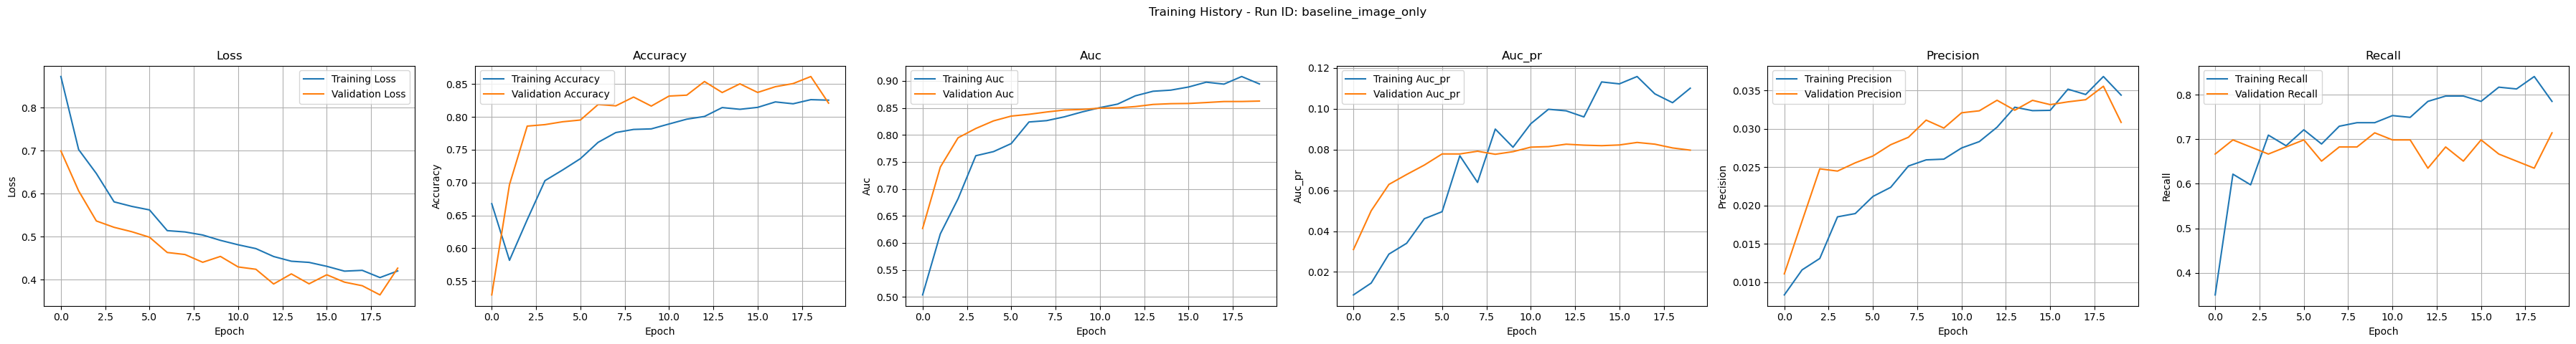

In [ ]:
if history_img_only:
    print("Plotting training history for image-only CNN...")
    metrics_to_plot = ['loss', 'accuracy', 'auc', 'auc_pr', 'precision', 'recall']
    run_id = "baseline_image_only"
    plot_training_history(history_img_only, metrics_to_plot, run_id, DEFAULT_OUTPUT_DIR)
else:
    print("No training history available for image-only model.")

### 3.3 Baseline 3: Combined Features (Image + Structured)


In [ ]:
# Ensure image paths from Part 2 are available:
# train_image_paths, val_image_paths, test_image_paths
# And labels: y_train, y_val, y_test

# --- 1. Define or Load Image Feature Extractor Model ---
# We need a model that outputs image features before the final classification layer.
# We can create this from the base_model used previously.

# Parameters for the feature extractor (consistent with previous definitions)
IMG_FE_BASE_MODEL_NAME = 'MobileNetV2' # Or use args.base_model if running in a script-like way
IMG_FE_DENSE_UNITS = 128       # Or use args.dense_units_img

print(f"\n--- Defining Image Feature Extractor (Base: {IMG_FE_BASE_MODEL_NAME}) ---")
img_fe_input = Input(shape=IMG_SHAPE, name='image_input_for_fe')

if IMG_FE_BASE_MODEL_NAME == 'MobileNetV2':
    base_fe_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', input_tensor=img_fe_input)
else:
    raise ValueError(f"Unsupported base model name for feature extraction: {IMG_FE_BASE_MODEL_NAME}")

base_fe_model.trainable = False # Keep it frozen for feature extraction
print(f"Base model '{IMG_FE_BASE_MODEL_NAME}' for feature extraction loaded and frozen.")

# Get features after pooling and optional dense layer
x_fe = base_fe_model.output
x_fe = layers.GlobalAveragePooling2D(name='img_fe_gap')(x_fe)
if IMG_FE_DENSE_UNITS > 0:
    x_fe = layers.Dense(IMG_FE_DENSE_UNITS, activation='relu', name='img_fe_dense')(x_fe)
image_feature_output = x_fe

image_feature_extractor_model = Model(inputs=img_fe_input, outputs=image_feature_output)
print("Image feature extractor model built.")
image_feature_extractor_model.summary(line_length=100)


# --- 2. Prepare Image Datasets for Feature Extraction (No Labels Needed for predict) ---
# We need a dataset that yields only processed images
def load_and_preprocess_image_for_fe(image_path):
    # This function should be identical to load_and_preprocess_image_only, but returns only the image
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        if IMG_FE_BASE_MODEL_NAME == 'MobileNetV2': # Ensure consistent preprocessing
            img = mobilenet_preprocess(img)
        else:
            img = tf.cast(img, tf.float32) / 255.0
        return img
    except Exception as e:
        tf.print(f"Warning: Error processing image {image_path} for FE: {e}. Returning zeros.")
        return tf.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

def prepare_dataset_for_fe_predict(image_paths, batch_size_param):
    if image_paths is None: return None
    ds = tf.data.Dataset.from_tensor_slices(image_paths)
    ds = ds.map(load_and_preprocess_image_for_fe, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size_param) # Use the same batch size as for training, or a specific one for prediction
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Using a consistent batch size (can be args.batch_size from main script or a notebook default)
NOTEBOOK_PREDICT_BATCH_SIZE = 64 # Or NOTEBOOK_IMG_ONLY_BATCH_SIZE, or args.batch_size

print(f"\nPreparing image datasets for feature extraction with batch size: {NOTEBOOK_PREDICT_BATCH_SIZE}...")
if 'train_image_paths' in locals() and train_image_paths is not None:
    train_ds_img_fe_predict = prepare_dataset_for_fe_predict(train_image_paths, NOTEBOOK_PREDICT_BATCH_SIZE)
    val_ds_img_fe_predict = prepare_dataset_for_fe_predict(val_image_paths, NOTEBOOK_PREDICT_BATCH_SIZE) # Also for val if needed for tuning XGB
    test_ds_img_fe_predict = prepare_dataset_for_fe_predict(test_image_paths, NOTEBOOK_PREDICT_BATCH_SIZE)
    print("Image datasets for feature extraction prepared.")

    # --- 3. Extract Image Features ---
    print("\nExtracting image features (this may take some time)...")
    img_features_train = image_feature_extractor_model.predict(train_ds_img_fe_predict, verbose=1)
    img_features_val = image_feature_extractor_model.predict(val_ds_img_fe_predict, verbose=1)
    img_features_test = image_feature_extractor_model.predict(test_ds_img_fe_predict, verbose=1)

    print(f"Shape of extracted training image features: {img_features_train.shape}")
    print(f"Shape of extracted validation image features: {img_features_val.shape}")
    print(f"Shape of extracted test image features: {img_features_test.shape}")
else:
    print("Training image paths not found. Skipping image feature extraction.")
    img_features_train, img_features_val, img_features_test = None, None, None


# Extract image features for baseline 3 (Combined Features)
FEATURE_EXTRACTION_BATCH_SIZE = 64

print("Setting up image feature extractor...")

# Define feature extractor model
img_fe_input = Input(shape=IMG_SHAPE, name='image_input_fe')
base_fe_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', 
                           input_tensor=img_fe_input)
base_fe_model.trainable = False

# Extract features after pooling and dense layer
x_fe = base_fe_model.output
x_fe = layers.GlobalAveragePooling2D(name='gap_fe')(x_fe)
x_fe = layers.Dense(128, activation='relu', name='dense_fe')(x_fe)

image_feature_extractor = Model(inputs=img_fe_input, outputs=x_fe)
print("Image feature extractor created.")

def load_and_preprocess_image_for_fe(image_path):
    """Load and preprocess image for feature extraction."""
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        img = mobilenet_preprocess(img)
        return img
    except Exception as e:
        tf.print(f"Error processing image {image_path}: {e}")
        return tf.zeros(IMG_SHAPE)

def prepare_dataset_for_fe(image_paths, batch_size):
    """Prepare dataset for feature extraction."""
    if image_paths is None:
        return None
    ds = tf.data.Dataset.from_tensor_slices(image_paths)
    ds = ds.map(load_and_preprocess_image_for_fe, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

print("Preparing datasets for feature extraction...")
if 'train_image_paths' in locals() and train_image_paths is not None:
    train_ds_fe = prepare_dataset_for_fe(train_image_paths, FEATURE_EXTRACTION_BATCH_SIZE)
    val_ds_fe = prepare_dataset_for_fe(val_image_paths, FEATURE_EXTRACTION_BATCH_SIZE)
    test_ds_fe = prepare_dataset_for_fe(test_image_paths, FEATURE_EXTRACTION_BATCH_SIZE)

    print("Extracting image features...")
    img_features_train = image_feature_extractor.predict(train_ds_fe, verbose=1)
    img_features_val = image_feature_extractor.predict(val_ds_fe, verbose=1)
    img_features_test = image_feature_extractor.predict(test_ds_fe, verbose=1)

    print(f"Training features shape: {img_features_train.shape}")
    print(f"Validation features shape: {img_features_val.shape}")
    print(f"Test features shape: {img_features_test.shape}")
else:
    print("Image paths not available. Skipping feature extraction.")
    img_features_train, img_features_val, img_features_test = None, None, None


--- Defining Image Feature Extractor (Base: MobileNetV2) ---
Base model 'MobileNetV2' for feature extraction loaded and frozen.
Image feature extractor model built.
Model: "model_10"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image_input_for_fe (InputLayer)  [(None, 224, 224, 3)  0          []                               
                                 ]                                                                  
                                                                                                    
 Conv1 (Conv2D)                  (None, 112, 112, 32)  864         ['image_input_for_fe[0][0]']     
                                                                                                    
 bn_Conv1 (BatchNormalization)   (None, 112, 112, 32)  128         ['Conv1[0][0]']                  
        

#### Feature Combination


In [ ]:
# Ensure processed structured features from Part 2 are available:
# X_train_tab_processed, X_val_tab_processed, X_test_tab_processed

# Combine image features with structured features
if img_features_train is not None and X_train_tab_processed is not None:
    print("Combining image features with structured features...")

    X_train_combined = np.hstack((img_features_train, X_train_tab_processed))
    X_val_combined = np.hstack((img_features_val, X_val_tab_processed))
    X_test_combined = np.hstack((img_features_test, X_test_tab_processed))

    print(f"Combined training features shape: {X_train_combined.shape}")
    print(f"Combined validation features shape: {X_val_combined.shape}")
    print(f"Combined test features shape: {X_test_combined.shape}")
else:
    print("Image features or structured features not available. Skipping combination.")
    X_train_combined, X_val_combined, X_test_combined = None, None, None


--- Concatenating Image Features with Processed Structured Features ---
Shape of combined training features for Baseline 3: (32000, 170)
Shape of combined validation features for Baseline 3: (8000, 170)
Shape of combined test features for Baseline 3: (10000, 170)


In [ ]:

# Train XGBoost on combined features
if X_train_combined is not None and y_train is not None:
    print("Training Baseline 3: XGBoost on Combined Features")

    # Calculate scale_pos_weight
    count_neg = np.sum(y_train == 0)
    count_pos = np.sum(y_train == 1)
    
    scale_pos_weight = 1.0
    if count_pos > 0 and count_neg > 0:
        scale_pos_weight = count_neg / count_pos
        print(f"Scale pos weight: {scale_pos_weight:.2f}")

    # Train XGBoost model
    xgb_combined_model = XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='auc',
        random_state=SEED,
        n_jobs=-1
    )

    print("Training XGBoost on combined features...")
    try:
        xgb_combined_model.fit(X_train_combined, y_train)
        print("XGBoost (combined features) training complete.")
    except Exception as e:
        print(f"Error during training: {e}")
        xgb_combined_model = None
else:
    print("Combined features not available. Skipping baseline 3.")
    xgb_combined_model = None


--- Training Baseline Model 3: XGBoost on Combined Features ---
Calculated scale_pos_weight for XGBoost (Baseline 3): 126.49
Training XGBoost model on combined features...


/home/shifrinn/.conda/envs/tf_conda_gpu_full/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:57:17] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (combined features) model training complete.


#### Baseline 3 Evaluation


In [ ]:
if xgb_combined_model is not None:
    print("\n--- Evaluating XGBoost Model (Combined Features) on Test Set ---")

    # Predict probabilities for AUC and class labels for other metrics
    y_test_pred_proba_xgb_comb = xgb_combined_model.predict_proba(X_test_combined)[:, 1]
    y_test_pred_xgb_comb = xgb_combined_model.predict(X_test_combined)

    # Calculate metrics
    try:
        accuracy_xgb_comb = accuracy_score(y_test, y_test_pred_xgb_comb)
        balanced_accuracy_xgb_comb = balanced_accuracy_score(y_test, y_test_pred_xgb_comb)
        auc_xgb_comb = roc_auc_score(y_test, y_test_pred_proba_xgb_comb)
        precision_xgb_comb = precision_score(y_test, y_test_pred_xgb_comb, pos_label=1, zero_division=0)
        recall_xgb_comb = recall_score(y_test, y_test_pred_xgb_comb, pos_label=1, zero_division=0)
        f1_xgb_comb = f1_score(y_test, y_test_pred_xgb_comb, pos_label=1, zero_division=0)
        
        cm_xgb_comb = confusion_matrix(y_test, y_test_pred_xgb_comb)
        tn_xgb_comb, fp_xgb_comb, fn_xgb_comb, tp_xgb_comb = cm_xgb_comb.ravel()

        print("\nXGBoost (Combined Features) Test Set Performance:")
        print(f"  Accuracy: {accuracy_xgb_comb:.4f}")
        print(f"  Balanced Accuracy: {balanced_accuracy_xgb_comb:.4f}")
        print(f"  AUC (ROC): {auc_xgb_comb:.4f}")
        print(f"  Precision: {precision_xgb_comb:.4f}")
        print(f"  Recall: {recall_xgb_comb:.4f}")
        print(f"  F1-Score: {f1_xgb_comb:.4f}")
        print("  Confusion Matrix:")
        print(f"    TP: {tp_xgb_comb}, FP: {fp_xgb_comb}")
        print(f"    FN: {fn_xgb_comb}, TN: {tn_xgb_comb}")

        # Store results
        baseline_results['combined_features_xgb'] = {
            'accuracy': accuracy_xgb_comb,
            'balanced_accuracy': balanced_accuracy_xgb_comb,
            'auc': auc_xgb_comb,
            'precision_overall_or_class1': precision_xgb_comb,
            'recall_overall_or_class1': recall_xgb_comb,
            'f1_score_overall_or_class1': f1_xgb_comb,
            'TN': int(tn_xgb_comb), 'FP': int(fp_xgb_comb),
            'FN': int(fn_xgb_comb), 'TP': int(tp_xgb_comb),
            'confusion_matrix': cm_xgb_comb.tolist()
        }
    except Exception as e:
        print(f"Error during evaluation: {e}")
else:
    print("XGBoost combined model not trained. Skipping evaluation.")


--- Evaluating XGBoost Model (Combined Features) on Test Set ---

XGBoost (Combined Features) Test Set Performance:
  Accuracy: 0.9912
  Balanced Accuracy: 0.6314
  AUC (ROC): 0.9350
  Precision (Overall/Class 1): 0.4118
  Recall (Overall/Class 1): 0.2658
  F1-Score (Overall/Class 1): 0.3231
  True Negatives (TN): 9891
  False Positives (FP): 30
  False Negatives (FN): 58
  True Positives (TP): 21
  Confusion Matrix:
 [[9891   30]
 [  58   21]]


## 4. Main Multimodal Deep Learning Model


In [ ]:
# --- Configuration for this specific Multimodal Model Run ---
# These parameters can be adjusted for different experiments.

RUN_ID = f"Multimodal_Main_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
MODEL_OUTPUT_DIR = os.path.join(DEFAULT_OUTPUT_DIR, RUN_ID)
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
print(f"Model outputs will be saved to: {MODEL_OUTPUT_DIR}")

# Hyperparameters
MULTI_LEARNING_RATE = 1e-5
MULTI_BATCH_SIZE = 64
MULTI_MAX_EPOCHS = 100
MULTI_SHUFFLE_FACTOR = 50
MULTI_ES_MONITOR = 'val_recall'
MULTI_ES_PATIENCE = 20
MULTI_MAX_MINORITY_CLASS_WEIGHT = 100.0

# Architecture parameters
MULTI_DENSE_UNITS_IMG = 128
MULTI_DENSE_UNITS_TABULAR = [64, 32]
MULTI_DENSE_UNITS_COMBINED = 64
MULTI_DROPOUT_RATE_IMG = 0.1
MULTI_DROPOUT_RATE_COMBINED = 0.3

# Configuration dictionary
config = {
    'run_id': RUN_ID,
    'learning_rate': MULTI_LEARNING_RATE,
    'batch_size': MULTI_BATCH_SIZE,
    'max_epochs': MULTI_MAX_EPOCHS,
    'early_stopping_monitor': MULTI_ES_MONITOR,
    'early_stopping_patience': MULTI_ES_PATIENCE,
    'dense_units_img': MULTI_DENSE_UNITS_IMG,
    'dense_units_tabular': MULTI_DENSE_UNITS_TABULAR,
    'dense_units_combined': MULTI_DENSE_UNITS_COMBINED,
    'dropout_rate_img': MULTI_DROPOUT_RATE_IMG,
    'dropout_rate_combined': MULTI_DROPOUT_RATE_COMBINED,
    'seed': SEED
}

print("\nMultimodal Model Configuration:")
print(json.dumps(config, indent=2))

# Save configuration
config_path = os.path.join(MODEL_OUTPUT_DIR, 'model_config.json')
with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)
print(f"Configuration saved to: {config_path}")

Outputs for this multimodal run will be saved to: /sise/home/shifrinn/Big_Data_project/notebook_runs_output/Multimodal_Main_Run_20250517_153845

Multimodal Model Configuration:
{
  "run_id": "Multimodal_Main_Run_20250517_153845",
  "learning_rate": 1e-05,
  "batch_size": 64,
  "max_epochs": 100,
  "shuffle_buffer_factor": 50,
  "early_stopping_monitor": "val_recall",
  "early_stopping_patience": 20,
  "max_minority_class_weight": 100.0,
  "base_model": "MobileNetV2",
  "dense_units_img": 128,
  "dense_units_tabular": [
    64,
    32
  ],
  "dense_units_combined": 64,
  "dropout_rate_img": 0.1,
  "dropout_rate_combined": 0.3,
  "seed": 42,
  "mixed_precision_enabled_notebook": false
}
Multimodal run configuration saved to /sise/home/shifrinn/Big_Data_project/notebook_runs_output/Multimodal_Main_Run_20250517_153845/run_config_multimodal.json
Using default precision ('float32').


In [ ]:
# Ensure these variables from Part 2 are available:
# train_image_paths, X_train_tab_processed, y_train
# val_image_paths, X_val_tab_processed, y_val
# test_image_paths, X_test_tab_processed, y_test
# Also, global constants like IMG_HEIGHT, IMG_WIDTH, AUTOTUNE, SEED

print("\n--- Preparing Datasets for Main Multimodal Model ---")

# Re-use image loading function (ensure it's defined globally or in a previous cell)
# load_and_preprocess_image was defined in Cell 21 for image-only baseline.
# If args.base_model was used there, ensure it matches MULTI_BASE_MODEL_NAME or pass it.
# For clarity, let's assume load_and_preprocess_image function needs to know which base model for preprocessing.

def load_and_preprocess_image_for_multi(image_path):
    """Loads, decodes, resizes, and preprocesses an image for the multimodal model."""
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        
        if MULTI_BASE_MODEL_NAME == 'MobileNetV2': # Using the specific config for this model
            img = mobilenet_preprocess(img)
        else:
            img = tf.cast(img, tf.float32) / 255.0 # Default
        return img
    except Exception as e:
        tf.print(f"Warning: Error processing image {image_path} for multimodal: {e}. Returning zeros.")
        return tf.zeros(IMG_SHAPE)

def load_and_preprocess_multimodal(image_path, tabular_row, label):
    """Loads image, combines with tabular data, for multimodal input."""
    processed_image = load_and_preprocess_image_for_multi(image_path)
    inputs = {
        'image_input': processed_image,          # Key must match Input layer name
        'tabular_input': tf.cast(tabular_row, tf.float32) # Key must match Input layer name
    }
    return inputs, label

def prepare_dataset_multimodal(image_paths, tabular_data, labels, shuffle=False):
    """Creates and prepares a tf.data.Dataset for the multimodal model."""
    if image_paths is None or tabular_data is None or labels is None:
        print("Error: Missing one or more required data arrays (image_paths, tabular_data, labels).")
        return None
        
    ds = tf.data.Dataset.from_tensor_slices((image_paths, tabular_data, labels))
    ds = ds.map(load_and_preprocess_multimodal, num_parallel_calls=AUTOTUNE)

    if shuffle:
        shuffle_buffer_size = MULTI_BATCH_SIZE * MULTI_SHUFFLE_BUFFER_FACTOR
        print(f"Using shuffle buffer size for multimodal train: {shuffle_buffer_size}")
        ds = ds.shuffle(buffer_size=shuffle_buffer_size, seed=SEED)

    ds = ds.batch(MULTI_BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create datasets using the globally prepared X_..._tab_processed and y_...
if 'X_train_tab_processed' in locals() and X_train_tab_processed is not None:
    train_ds_multi = prepare_dataset_multimodal(train_image_paths, X_train_tab_processed, y_train, shuffle=True)
    val_ds_multi = prepare_dataset_multimodal(val_image_paths, X_val_tab_processed, y_val)
    test_ds_multi = prepare_dataset_multimodal(test_image_paths, X_test_tab_processed, y_test)
    print("Multimodal datasets prepared.")

    # Optional: Verify one batch
    if train_ds_multi:
        for batch_inputs, batch_labels in train_ds_multi.take(1):
            print("Image input batch shape:", batch_inputs['image_input'].shape)
            print("Tabular input batch shape:", batch_inputs['tabular_input'].shape)
            print("Label batch shape:", batch_labels.shape)
else:
    print("Processed tabular data or image paths not found. Skipping multimodal dataset preparation.")
    train_ds_multi, val_ds_multi, test_ds_multi = None, None, None

# Prepare datasets for multimodal model
print("Preparing multimodal datasets...")

def load_and_preprocess_image_multi(image_path):
    """Load and preprocess image for multimodal model."""
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        img = mobilenet_preprocess(img)
        return img
    except Exception as e:
        tf.print(f"Error processing image {image_path}: {e}")
        return tf.zeros(IMG_SHAPE)

def load_and_preprocess_multimodal(image_path, tabular_row, label):
    """Load and combine image and tabular data."""
    processed_image = load_and_preprocess_image_multi(image_path)
    inputs = {
        'image_input': processed_image,
        'tabular_input': tf.cast(tabular_row, tf.float32)
    }
    return inputs, label

def prepare_multimodal_dataset(image_paths, tabular_data, labels, shuffle=False):
    """Create multimodal tf.data.Dataset."""
    if image_paths is None or tabular_data is None or labels is None:
        print("Error: Missing required data for multimodal dataset.")
        return None
        
    ds = tf.data.Dataset.from_tensor_slices((image_paths, tabular_data, labels))
    ds = ds.map(load_and_preprocess_multimodal, num_parallel_calls=AUTOTUNE)

    if shuffle:
        shuffle_buffer = MULTI_BATCH_SIZE * MULTI_SHUFFLE_FACTOR
        ds = ds.shuffle(buffer_size=shuffle_buffer, seed=SEED)

    ds = ds.batch(MULTI_BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create multimodal datasets
if X_train_tab_processed is not None:
    train_ds_multi = prepare_multimodal_dataset(train_image_paths, X_train_tab_processed, y_train, shuffle=True)
    val_ds_multi = prepare_multimodal_dataset(val_image_paths, X_val_tab_processed, y_val)
    test_ds_multi = prepare_multimodal_dataset(test_image_paths, X_test_tab_processed, y_test)
    print("Multimodal datasets created.")

    # Verify batch structure
    if train_ds_multi:
        for batch_inputs, batch_labels in train_ds_multi.take(1):
            print(f"Image batch shape: {batch_inputs['image_input'].shape}")
            print(f"Tabular batch shape: {batch_inputs['tabular_input'].shape}")
            print(f"Label batch shape: {batch_labels.shape}")
else:
    print("Processed tabular data not available. Skipping multimodal dataset preparation.")
    train_ds_multi, val_ds_multi, test_ds_multi = None, None, None


--- Preparing Datasets for Main Multimodal Model ---
Using shuffle buffer size for multimodal train: 3200
Multimodal datasets prepared.
Image input batch shape: (64, 224, 224, 3)
Tabular input batch shape: (64, 42)
Label batch shape: (64,)


### 4.1 Model Architecture

In [ ]:
if num_processed_tabular_features > 0:
    print("Building Main Multimodal Model")

    # Define inputs
    image_input = Input(shape=IMG_SHAPE, name='image_input', dtype=tf.float32)
    tabular_input = Input(shape=(num_processed_tabular_features,), name='tabular_input', dtype=tf.float32)

    # Image branch
    print("Building image branch...")
    base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze base model
    
    x_img = base_model(image_input, training=False)
    x_img = layers.GlobalAveragePooling2D()(x_img)
    x_img = layers.Dense(MULTI_DENSE_UNITS_IMG, activation='relu')(x_img)
    x_img = layers.Dropout(MULTI_DROPOUT_RATE_IMG)(x_img)
    image_features = x_img

    # Tabular branch
    print("Building tabular branch...")
    x_tab = tabular_input
    for units in MULTI_DENSE_UNITS_TABULAR:
        x_tab = layers.Dense(units, activation='relu')(x_tab)
    tabular_features = x_tab

    # Fusion layer
    print("Combining branches...")
    combined_features = layers.concatenate([image_features, tabular_features])

    # Final classifier
    x_classifier = layers.Dense(MULTI_DENSE_UNITS_COMBINED, activation='relu')(combined_features)
    x_classifier = layers.Dropout(MULTI_DROPOUT_RATE_COMBINED)(x_classifier)
    output = layers.Dense(1, activation='sigmoid', name='output', dtype=tf.float32)(x_classifier)

    # Create model
    model_multi = Model(inputs=[image_input, tabular_input], outputs=output)
    print("Multimodal model architecture complete.")

    print("\nModel Summary:")
    model_multi.summary(line_length=120)
else:
    print("Processed tabular features not available. Skipping model building.")
    model_multi = None


--- Building Main Multimodal Model ---
Loading base model: MobileNetV2
Base model 'MobileNetV2' loaded and frozen.
Image branch built.
Structured features branch built.
Branches concatenated.
Classifier head built.
--- Main Multimodal Model Built Successfully ---

Main Multimodal Model Summary:
Model: "model_11"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 image_input (InputLayer)              [(None, 224, 224, 3)]      0             []                                      
                                                                                                                        
 mobilenetv2_1.00_224 (Functional)     (None, 7, 7, 1280)         2257984       ['image_input[0][0]']                   
                                                                                

### 4.2 Model Training


In [ ]:
# Retrieve class_weight_dict calculated in Part 2 (Data Handling)
# Ensure it's accessible in this scope or pass it as an argument
if 'class_weight_dict' not in locals(): # Should have been defined in Cell (approx) 11 for part 2
    print("Warning: class_weight_dict not found globally. Recalculating based on y_train for safety.")
    # This is a fallback, ideally it's consistently available from data prep
    if 'y_train' in locals() and y_train is not None:
        unique_y_train_labels_multi = np.unique(y_train)
        if len(unique_y_train_labels_multi) == 2:
            class_weights_array_multi = compute_class_weight('balanced', classes=unique_y_train_labels_multi, y=y_train)
            class_weight_dict_multi = dict(zip(unique_y_train_labels_multi, class_weights_array_multi))
            if 1 in class_weight_dict_multi and MULTI_MAX_MINORITY_CLASS_WEIGHT > 0:
                 original_weight = class_weight_dict_multi[1]
                 class_weight_dict_multi[1] = min(original_weight, MULTI_MAX_MINORITY_CLASS_WEIGHT)
                 if class_weight_dict_multi[1] < original_weight: print(f"Capping minority weight from {original_weight:.2f} to {class_weight_dict_multi[1]:.2f}")
            if 0 not in class_weight_dict_multi: class_weight_dict_multi[0] = 1.0
            if 1 not in class_weight_dict_multi: class_weight_dict_multi[1] = 1.0
            print(f"Recalculated class weights for multimodal: {class_weight_dict_multi}")
        else:
            class_weight_dict_multi = None
            print("Only one class in y_train for multimodal, cannot use class weights.")
    else:
        class_weight_dict_multi = None
        print("y_train not available, cannot calculate class weights for multimodal.")
elif class_weight_dict is None: # It was defined but explicitly set to None
    print("class_weight_dict is None. Training multimodal model without class weights.")
    class_weight_dict_multi = None
else: # Use the one from global/Part 2 scope
    class_weight_dict_multi = class_weight_dict
    print(f"Using pre-calculated class_weight_dict for multimodal: {class_weight_dict_multi}")


# Train multimodal model
if model_multi and train_ds_multi and val_ds_multi:
    print("Training Main Multimodal Model")

    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=MULTI_LEARNING_RATE)
    
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.AUC(curve='PR', name='auc_pr'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_multi.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    print("Model compiled.")

    # Setup callbacks
    early_stopping = EarlyStopping(
        monitor=MULTI_ES_MONITOR,
        patience=MULTI_ES_PATIENCE,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )
    callbacks = [early_stopping]
    
    # Use class weights if available
    current_class_weights = class_weight_dict if 'class_weight_dict' in locals() else None
    if current_class_weights:
        print(f"Using class weights: {current_class_weights}")
    else:
        print("Training without class weights.")

    print(f"Starting training for max {MULTI_MAX_EPOCHS} epochs...")
    history_multi = model_multi.fit(
        train_ds_multi,
        epochs=MULTI_MAX_EPOCHS,
        validation_data=val_ds_multi,
        callbacks=callbacks,
        class_weight=current_class_weights,
        verbose=2
    )
    print("Multimodal model training complete.")
else:
    print("Multimodal model or datasets not ready. Skipping training.")
    history_multi = None

Using pre-calculated class_weight_dict for multimodal: {0: 0.5039528804056821, 1: 63.745019920318725}

--- Training Main Multimodal Model ---
Compiling multimodal model...
Multimodal model compiled with metrics: ['accuracy', 'auc', 'auc_pr', 'precision', 'recall']
Setting up callbacks for multimodal training...
Early stopping mode for multimodal model: max for monitor 'val_recall'
Using class weights for multimodal training: {0: 0.5039528804056821, 1: 63.745019920318725}

Starting training for max 100 epochs...
Epoch 1/100
500/500 - 34s - loss: 0.6723 - accuracy: 0.5556 - auc: 0.6314 - auc_pr: 0.0167 - precision: 0.0113 - recall: 0.6454 - val_loss: 0.6365 - val_accuracy: 0.6764 - val_auc: 0.7519 - val_auc_pr: 0.0626 - val_precision: 0.0161 - val_recall: 0.6667 - 34s/epoch - 68ms/step
Epoch 2/100
500/500 - 31s - loss: 0.6272 - accuracy: 0.6329 - auc: 0.6931 - auc_pr: 0.0371 - precision: 0.0130 - recall: 0.6135 - val_loss: 0.5950 - val_accuracy: 0.7492 - val_auc: 0.8006 - val_auc_pr: 0.1

### 4.3 Model Evaluation and Threshold Optimization


In [ ]:
# Evaluate multimodal model with threshold optimization
main_model_results = {'config': config}

if model_multi and test_ds_multi and history_multi:
    print("Evaluating Main Multimodal Model")

    # Standard evaluation (threshold = 0.5)
    print("Standard evaluation (threshold = 0.5)...")
    results_keras = model_multi.evaluate(test_ds_multi, verbose=1)
    results_dict = dict(zip(model_multi.metrics_names, results_keras))
    
    print("\nKeras Test Performance:")
    for name, value in results_dict.items():
        print(f"  {name}: {value:.4f}")
    
    main_model_results["test_metrics_default_thresh"] = {
        k: float(v) for k, v in results_dict.items()
    }

    # Threshold optimization on validation set
    print("\nOptimizing threshold on validation set...")
    y_val_pred_proba = model_multi.predict(val_ds_multi, verbose=1)

    thresholds = np.linspace(0.01, 0.99, 99)
    best_bal_acc = 0
    optimal_threshold = 0.5

    for thresh in thresholds:
        y_val_pred_binary = (y_val_pred_proba > thresh).astype(int)
        bal_acc = balanced_accuracy_score(y_val, y_val_pred_binary)
        if bal_acc > best_bal_acc:
            best_bal_acc = bal_acc
            optimal_threshold = thresh
    
    print(f"Optimal threshold: {optimal_threshold:.4f} (Balanced Accuracy: {best_bal_acc:.4f})")
    main_model_results["optimal_threshold_val_bal_acc"] = float(optimal_threshold)

    # Evaluate on test set with optimal threshold
    print(f"Evaluating on test set with optimal threshold ({optimal_threshold:.4f})...")
    y_test_pred_proba_multi = model_multi.predict(test_ds_multi, verbose=1)
    y_test_pred_optimal_multi = (y_test_pred_proba_multi > optimal_threshold).astype(int)

    # Calculate detailed metrics
    acc_opt = accuracy_score(y_test, y_test_pred_optimal_multi)
    bal_acc_opt = balanced_accuracy_score(y_test, y_test_pred_optimal_multi)
    auc_opt = roc_auc_score(y_test, y_test_pred_proba_multi)
    prec_opt = precision_score(y_test, y_test_pred_optimal_multi, zero_division=0, pos_label=1)
    rec_opt = recall_score(y_test, y_test_pred_optimal_multi, zero_division=0, pos_label=1)
    f1_opt = f1_score(y_test, y_test_pred_optimal_multi, zero_division=0, pos_label=1)
    cm_opt = confusion_matrix(y_test, y_test_pred_optimal_multi)
    tn_opt, fp_opt, fn_opt, tp_opt = cm_opt.ravel()
    
    print(f"\nMultimodal Test Performance (Threshold = {optimal_threshold:.4f}):")
    print(f"  Accuracy: {acc_opt:.4f}")
    print(f"  Balanced Accuracy: {bal_acc_opt:.4f}")
    print(f"  AUC (ROC): {auc_opt:.4f}")
    print(f"  Precision: {prec_opt:.4f}")
    print(f"  Recall: {rec_opt:.4f}")
    print(f"  F1-Score: {f1_opt:.4f}")
    print("  Confusion Matrix:")
    print(f"    TP: {tp_opt}, FP: {fp_opt}")
    print(f"    FN: {fn_opt}, TN: {tn_opt}")

    main_model_results["test_metrics_optimal_thresh_bal_acc"] = {
        'threshold': float(optimal_threshold),
        'accuracy': float(acc_opt),
        'balanced_accuracy': float(bal_acc_opt),
        'auc': float(auc_opt),
        'precision_class1': float(prec_opt),
        'recall_class1': float(rec_opt),
        'f1_score_class1': float(f1_opt),
        'TP': int(tp_opt), 'FP': int(fp_opt),
        'TN': int(tn_opt), 'FN': int(fn_opt),
        'confusion_matrix': cm_opt.tolist()
    }
else:
    print("Multimodal model not trained or test data not ready. Skipping evaluation.")


--- Evaluating Main Multimodal Model on Test Set ---
Evaluating with model.evaluate() (default 0.5 threshold for accuracy):
157/157 [==============================] - 7s 45ms/step - loss: 0.4838 - accuracy: 0.8293 - auc: 0.8514 - auc_pr: 0.0787 - precision: 0.0338 - recall: 0.7468

Multimodal Model Keras Test Set Performance (Threshold = 0.5 for accuracy):
  Test loss: 0.4838
  Test accuracy: 0.8293
  Test auc: 0.8514
  Test auc_pr: 0.0787
  Test precision: 0.0338
  Test recall: 0.7468

--- Finding Optimal Threshold on Validation Set for Multimodal Model (Max Balanced Accuracy) ---
Predicting on validation set (multimodal)...
125/125 [==============================] - 6s 44ms/step
Optimal threshold for multimodal model (on val): 0.5100 (Maximizes Balanced Accuracy: 0.8098)

Evaluating multimodal model on test set (Optimal Threshold = 0.5100)...
Predicting on test set (multimodal)...
157/157 [==============================] - 7s 44ms/step
------------------------------
Multimodal Test 

Main multimodal model results saved to /sise/home/shifrinn/Big_Data_project/notebook_runs_output/Multimodal_Main_Run_20250517_153845/test_results_multimodal.json
Saving training history for multimodal model...
Multimodal training history saved to /sise/home/shifrinn/Big_Data_project/notebook_runs_output/Multimodal_Main_Run_20250517_153845/training_history_multimodal.csv
Plotting training history for multimodal model...
Plotting history for 27 epochs for run Multimodal_Main_Run_20250517_153845...
Training history plot saved to /sise/home/shifrinn/Big_Data_project/notebook_runs_output/Multimodal_Main_Run_20250517_153845/training_history_Multimodal_Main_Run_20250517_153845.png


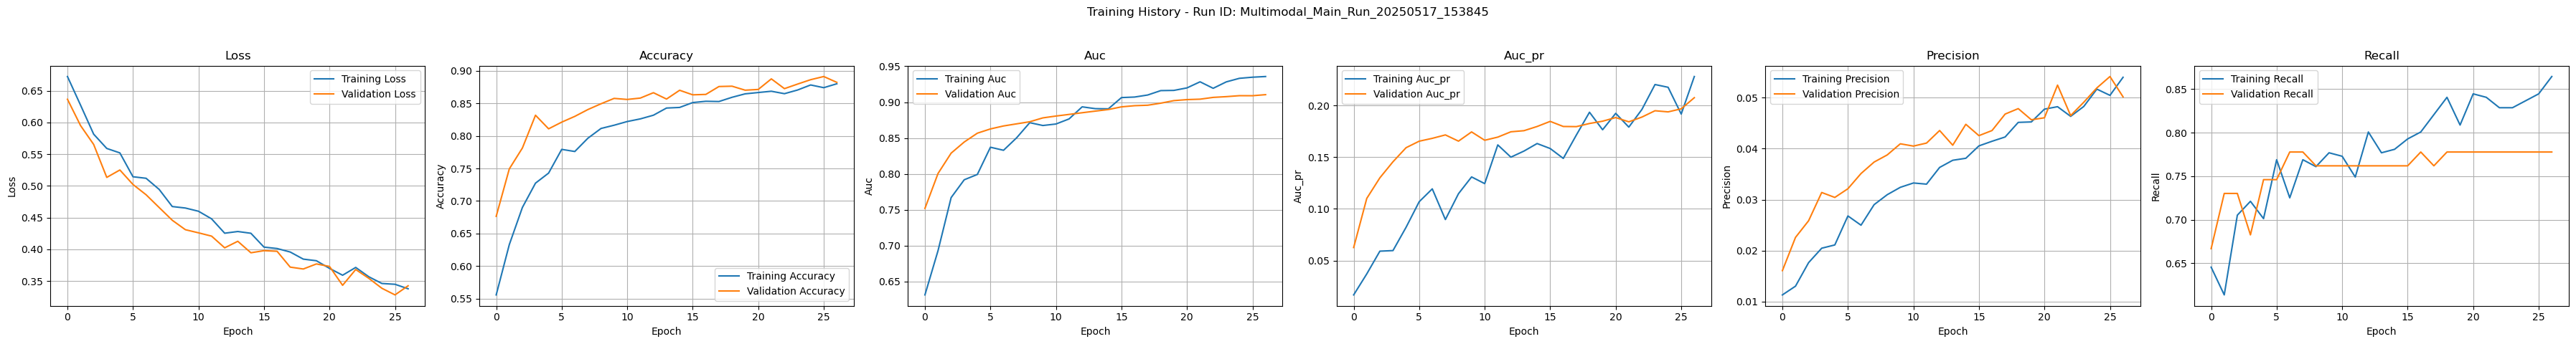

Saving final trained multimodal model...
Trained multimodal model saved to /sise/home/shifrinn/Big_Data_project/notebook_runs_output/Multimodal_Main_Run_20250517_153845/final_multimodal_model.keras


In [ ]:
# Save model and results
if model_multi and history_multi:
    # Save results
    results_path = os.path.join(MODEL_OUTPUT_DIR, 'test_results.json')
    try:
        with open(results_path, 'w') as f:
            json.dump(main_model_results, f, indent=4)
        print(f"Results saved to: {results_path}")
    except Exception as e:
        print(f"Error saving results: {e}")

    # Save training history
    if 'loss' in history_multi.history:
        history_df = pd.DataFrame(history_multi.history)
        history_path = os.path.join(MODEL_OUTPUT_DIR, 'training_history.csv')
        history_df.to_csv(history_path, index=False)
        print(f"Training history saved to: {history_path}")

        # Plot training history
        print("Plotting training history...")
        metrics_to_plot = ['loss', 'accuracy', 'auc', 'auc_pr', 'precision', 'recall']
        plot_training_history(history_multi, metrics_to_plot, RUN_ID, MODEL_OUTPUT_DIR)

    # Save trained model
    print("Saving trained model...")
    model_save_path = os.path.join(MODEL_OUTPUT_DIR, 'final_model.keras')
    try:
        model_multi.save(model_save_path)
        print(f"Model saved to: {model_save_path}")
    except Exception as e:
        print(f"Error saving model: {e}")
else:
    print("Multimodal model not trained. Skipping save operations.")

## 5. Results Analysis and Model Comparison


In [ ]:
# Collect results from all models for comparison
all_model_results = []

# Baseline 1: Structured Features Only
if 'baseline_results' in locals() and 'structured_features_only_xgb' in baseline_results:
    res = baseline_results['structured_features_only_xgb']
    all_model_results.append({
        'Model Name': 'Baseline 1: Structured Only (XGBoost)',
        'AUC (ROC)': res.get('auc'),
        'Balanced Accuracy': res.get('balanced_accuracy'),
        'Accuracy': res.get('accuracy'),
        'F1 (Class 1)': res.get('f1_score_overall_or_class1'),
        'Precision (Class 1)': res.get('precision_overall_or_class1'),
        'Recall (Class 1)': res.get('recall_overall_or_class1')
    })
    print("Retrieved results for Baseline 1")

# Baseline 2: Image Only
if 'baseline_results' in locals() and 'image_only_cnn' in baseline_results:
    res = baseline_results['image_only_cnn']
    all_model_results.append({
        'Model Name': 'Baseline 2: Image Only (CNN)',
        'AUC (ROC)': res.get('auc'),
        'Balanced Accuracy': res.get('balanced_accuracy'),
        'Accuracy': res.get('accuracy'),
        'F1 (Class 1)': res.get('f1_score_overall_or_class1'),
        'Precision (Class 1)': res.get('precision_overall_or_class1'),
        'Recall (Class 1)': res.get('recall_overall_or_class1')
    })
    print("Retrieved results for Baseline 2")

# Baseline 3: Combined Features
if 'baseline_results' in locals() and 'combined_features_xgb' in baseline_results:
    res = baseline_results['combined_features_xgb']
    all_model_results.append({
        'Model Name': 'Baseline 3: Combined Features (XGBoost)',
        'AUC (ROC)': res.get('auc'),
        'Balanced Accuracy': res.get('balanced_accuracy'),
        'Accuracy': res.get('accuracy'),
        'F1 (Class 1)': res.get('f1_score_overall_or_class1'),
        'Precision (Class 1)': res.get('precision_overall_or_class1'),
        'Recall (Class 1)': res.get('recall_overall_or_class1')
    })
    print("Retrieved results for Baseline 3")

# Main Multimodal Model
if 'main_model_results' in locals() and 'test_metrics_optimal_thresh_bal_acc' in main_model_results:
    res = main_model_results['test_metrics_optimal_thresh_bal_acc']
    all_model_results.append({
        'Model Name': 'Main: Multimodal Deep Learning',
        'AUC (ROC)': res.get('auc'),
        'Balanced Accuracy': res.get('balanced_accuracy'),
        'Accuracy': res.get('accuracy'),
        'F1 (Class 1)': res.get('f1_score_class1'),
        'Precision (Class 1)': res.get('precision_class1'),
        'Recall (Class 1)': res.get('recall_class1'),
        'Optimal Threshold': res.get('threshold')
    })
    print("Retrieved results for Main Multimodal Model")

# Create comparison DataFrame
if all_model_results:
    results_df = pd.DataFrame(all_model_results)
    results_df = results_df.set_index('Model Name')
    print("\nResults comparison DataFrame created.")
else:
    print("No model results found for comparison.")
    results_df = pd.DataFrame()

Retrieved results for Baseline 1: Structured Only (XGBoost)
Retrieved results for Baseline 2: Image Only (CNN)
Retrieved results for Baseline 3: Combined Features (XGBoost)
Retrieved results for Main Multimodal Model (Opt. Bal. Acc.)

--- Results Summary DataFrame Created ---


In [ ]:
if not results_df.empty:
    print("\n" + "="*60)
    print("COMPREHENSIVE MODEL PERFORMANCE COMPARISON")
    print("="*60)
    
    # Define display columns
    key_metrics = ['AUC (ROC)', 'Balanced Accuracy', 'Accuracy', 'Recall (Class 1)']
    display_cols = [col for col in key_metrics if col in results_df.columns]
    
    # Format and highlight results
    formatters = {col: "{:.4f}" for col in display_cols}
    
    styled_df = results_df[display_cols].style.format(formatters)\
        .highlight_max(subset=['AUC (ROC)', 'Balanced Accuracy', 'Recall (Class 1)'], 
                      color='lightgreen', axis=0)\
        .set_caption("Model Performance Comparison on Test Set")\
        .set_table_styles([
            {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]}
        ])
    
    display(styled_df)

    # Save results table
    summary_path = os.path.join(DEFAULT_OUTPUT_DIR, "model_comparison_summary.csv")
    try:
        results_df[display_cols].to_csv(summary_path)
        print(f"\nResults summary saved to: {summary_path}")
    except Exception as e:
        print(f"Error saving summary: {e}")
        
    # Print key findings
    if 'AUC (ROC)' in results_df.columns:
        best_auc_model = results_df['AUC (ROC)'].idxmax()
        best_auc_value = results_df['AUC (ROC)'].max()
        print(f"\n📊 Best AUC Performance: {best_auc_model} ({best_auc_value:.4f})")
        
    if 'Balanced Accuracy' in results_df.columns:
        best_bal_acc_model = results_df['Balanced Accuracy'].idxmax()
        best_bal_acc_value = results_df['Balanced Accuracy'].max()
        print(f"⚖️  Best Balanced Accuracy: {best_bal_acc_model} ({best_bal_acc_value:.4f})")
        
    if 'Recall (Class 1)' in results_df.columns:
        best_recall_model = results_df['Recall (Class 1)'].idxmax()
        best_recall_value = results_df['Recall (Class 1)'].max()
        print(f"🎯 Best Recall (Critical for Medical): {best_recall_model} ({best_recall_value:.4f})")
else:
    print("No results available for comparison.")


--- Comparative Performance of All Models (Test Set) ---


,AUC (ROC),Balanced Accuracy,Accuracy
Model Name,,,
Baseline 1: Structured Only (XGBoost),0.9294,0.6806,0.9892
Baseline 2: Image Only (CNN),0.8071,0.7324,0.8178
Baseline 3: Combined Feat. (XGBoost),0.9350,0.6314,0.9912
Main: Multimodal (Deep) (Opt. Bal. Acc.),0.8516,0.7935,0.8394



Summary table (displayed columns) saved to: /sise/home/shifrinn/Big_Data_project/notebook_runs_output/model_comparison_summary.csv



--- Generating Comparative Plots (Separate Figure for Each Metric) ---
Using fixed model order for plots: ['Baseline 1: Structured Only (XGBoost)', 'Baseline 2: Image Only (CNN)', 'Baseline 3: Combined Feat. (XGBoost)', 'Main: Multimodal (Deep) (Opt. Bal. Acc.)']
Comparative plot for 'AUC (ROC)' saved to: /sise/home/shifrinn/Big_Data_project/notebook_runs_output/model_comparison_AUC_ROC.png


/tmp/ipykernel_2370818/2902419387.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_current = sns.barplot(x=fixed_model_order, y=metric_values_in_order, palette="viridis")


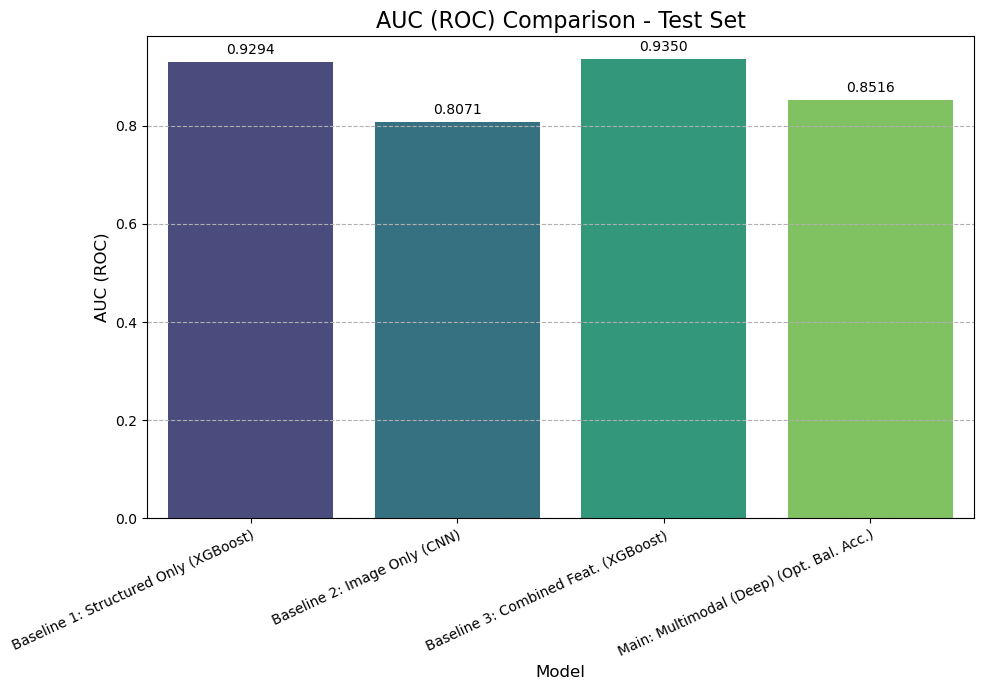

/tmp/ipykernel_2370818/2902419387.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_current = sns.barplot(x=fixed_model_order, y=metric_values_in_order, palette="viridis")


Comparative plot for 'Balanced Accuracy' saved to: /sise/home/shifrinn/Big_Data_project/notebook_runs_output/model_comparison_Balanced_Accuracy.png


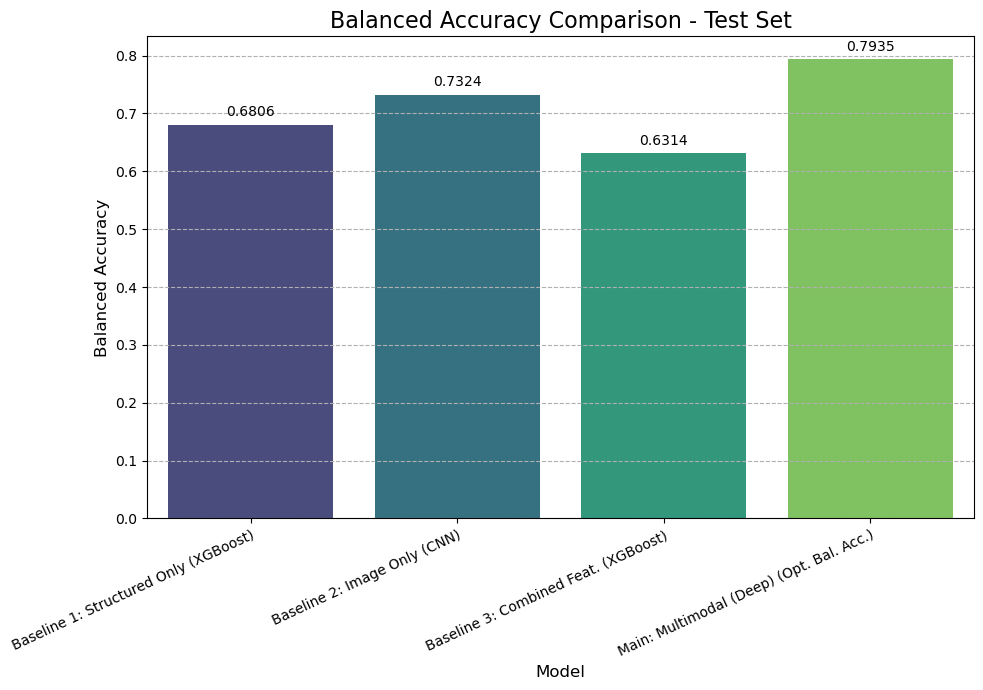

/tmp/ipykernel_2370818/2902419387.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_current = sns.barplot(x=fixed_model_order, y=metric_values_in_order, palette="viridis")


Comparative plot for 'Accuracy' saved to: /sise/home/shifrinn/Big_Data_project/notebook_runs_output/model_comparison_Accuracy.png


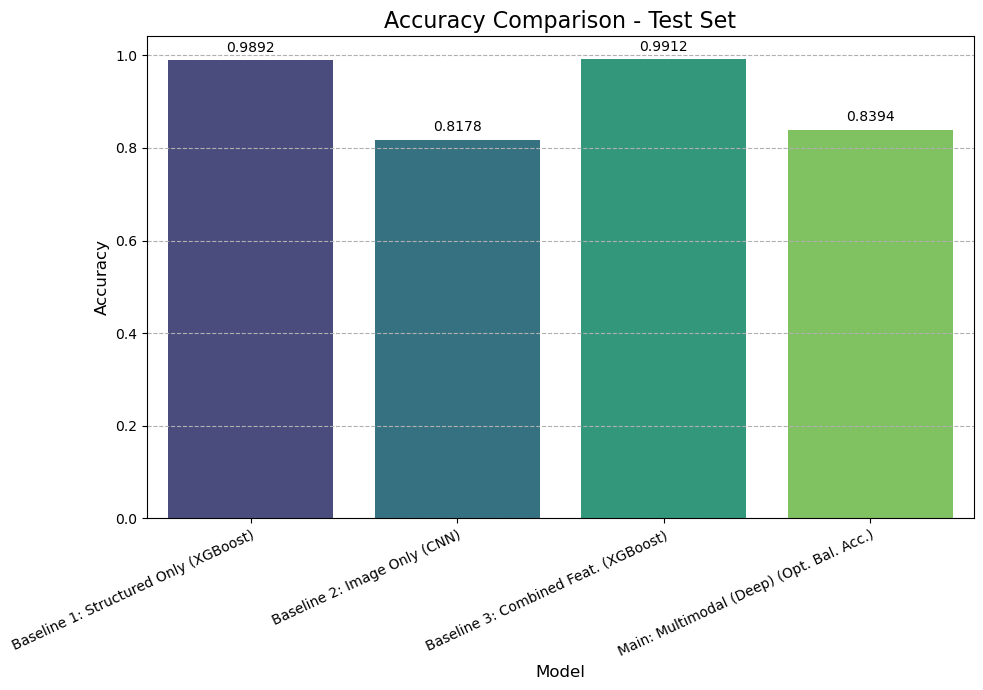

In [ ]:
if not results_df.empty:
    print("\nGenerating comparative performance plots...")
    
    # Metrics to visualize
    plot_metrics = ['AUC (ROC)', 'Balanced Accuracy', 'Accuracy']
    valid_metrics = [m for m in plot_metrics if m in results_df.columns 
                    and not results_df[m].isnull().all()]

    if valid_metrics:
        model_order = results_df.index.tolist()
        
        for metric in valid_metrics:
            plt.figure(figsize=(10, 6))
            
            metric_values = results_df.loc[model_order, metric]
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Distinct colors
            
            bars = plt.bar(range(len(model_order)), metric_values, 
                          color=colors[:len(model_order)], alpha=0.8)
            
            plt.title(f'{metric} Comparison Across Models', fontsize=16, fontweight='bold')
            plt.ylabel(metric, fontsize=12)
            plt.xlabel('Model', fontsize=12)
            plt.xticks(range(len(model_order)), 
                      [name.replace(' ', '\n') for name in model_order], 
                      rotation=0, ha='center')
            plt.grid(axis='y', alpha=0.3)
            
            # Add value labels on bars
            for i, (bar, value) in enumerate(zip(bars, metric_values)):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                        f'{value:.4f}', ha='center', va='bottom', 
                        fontweight='bold', fontsize=10)
            
            plt.tight_layout()
            
            # Save plot
            safe_metric = metric.replace(' ', '_').replace('(', '').replace(')', '')
            plot_path = os.path.join(DEFAULT_OUTPUT_DIR, f"comparison_{safe_metric}.png")
            try:
                plt.savefig(plot_path, dpi=300, bbox_inches='tight')
                print(f"Plot saved: {plot_path}")
            except Exception as e:
                print(f"Error saving plot for {metric}: {e}")
            
            plt.show()
            plt.close()
    else:
        print("No valid metrics found for plotting.")
else:
    print("No results available for plotting.")

### 5.1 Detailed Performance Metrics


In [ ]:

all_model_performance_data_final = []

# --- Helper to extract Keras loss (Log-loss) ---
def get_keras_log_loss(model_results_dict):
    if model_results_dict and 'test_metrics_default_thresh' in model_results_dict:
        return model_results_dict['test_metrics_default_thresh'].get('loss')
    elif model_results_dict and 'keras_test_loss' in model_results_dict: # For baselines not using optimal threshold structure
        return model_results_dict.get('keras_test_loss')
    return np.nan

# --- Baseline 1: Structured Features Only (XGBoost) ---
if 'baseline_results' in locals() and 'structured_features_only_xgb' in baseline_results:
    res_b1 = baseline_results['structured_features_only_xgb']
    all_model_performance_data_final.append({
        'Model': 'Baseline 1: Structured Only (XGB)',
        'AUC (ROC)': res_b1.get('auc'),
        'Accuracy': res_b1.get('accuracy'),
        'Balanced Accuracy': res_b1.get('balanced_accuracy'),
        'F1 (Class 1)': res_b1.get('f1_score_overall_or_class1'),
        'Precision (Class 1)': res_b1.get('precision_overall_or_class1'), # <<< ADDED/VERIFIED KEY
        'Recall (Class 1)': res_b1.get('recall_overall_or_class1'),       # <<< ADDED/VERIFIED KEY
        'Log-loss': np.nan # Or calculate: log_loss(y_test, y_test_pred_proba_xgb_sf) if probas were stored
        # Add TP, FP, TN, FN if desired for the table data source directly
        # 'TP': res_b1.get('TP'), 'FP': res_b1.get('FP'), 'TN': res_b1.get('TN'), 'FN': res_b1.get('FN')
    })
    print("Retrieved results for Baseline 1: Structured Only (XGBoost)")

# --- Baseline 2: Image Data Only (CNN) ---
if 'baseline_results' in locals() and 'image_only_cnn' in baseline_results:
    res_b2 = baseline_results['image_only_cnn']
    all_model_performance_data_final.append({
        'Model': 'Baseline 2: Image Only (CNN)',
        'AUC (ROC)': res_b2.get('auc'),
        'Accuracy': res_b2.get('accuracy'),
        'Balanced Accuracy': res_b2.get('balanced_accuracy'),
        'F1 (Class 1)': res_b2.get('f1_score_overall_or_class1'),
        'Precision (Class 1)': res_b2.get('precision_overall_or_class1'), # <<< ADDED/VERIFIED KEY
        'Recall (Class 1)': res_b2.get('recall_overall_or_class1'),       # <<< ADDED/VERIFIED KEY
        'Log-loss': res_b2.get('keras_test_loss') # From model.evaluate()
        # 'TP': res_b2.get('TP'), 'FP': res_b2.get('FP'), 'TN': res_b2.get('TN'), 'FN': res_b2.get('FN')
    })
    print("Retrieved results for Baseline 2: Image Only (CNN)")

# --- Baseline 3: Combined Features (Image Feat + Structured) + XGBoost ---
if 'baseline_results' in locals() and 'combined_features_xgb' in baseline_results:
    res_b3 = baseline_results['combined_features_xgb']
    all_model_performance_data_final.append({
        'Model': 'Baseline 3: Combined Feat. (XGBoost)',
        'AUC (ROC)': res_b3.get('auc'),
        'Accuracy': res_b3.get('accuracy'),
        'Balanced Accuracy': res_b3.get('balanced_accuracy'),
        'F1 (Class 1)': res_b3.get('f1_score_overall_or_class1'),
        'Precision (Class 1)': res_b3.get('precision_overall_or_class1'), # <<< ADDED/VERIFIED KEY
        'Recall (Class 1)': res_b3.get('recall_overall_or_class1'),       # <<< ADDED/VERIFIED KEY
        'Log-loss': np.nan # Or calculate: log_loss(y_test, y_test_pred_proba_xgb_comb)
        # 'TP': res_b3.get('TP'), 'FP': res_b3.get('FP'), 'TN': res_b3.get('TN'), 'FN': res_b3.get('FN')
    })
    print("Retrieved results for Baseline 3: Combined Features (XGBoost)")

# --- Main Multimodal Model Results ---
# Choose results from optimal threshold for F1, Acc, Bal Acc, but default Keras evaluation for Log-loss
if 'main_model_run_results' in locals():
    res_main_opt = None
    model_name_suffix = ""
    # Prioritize results from threshold optimized for balanced accuracy
    if 'test_metrics_optimal_thresh_bal_acc' in main_model_run_results:
        res_main_opt = main_model_run_results['test_metrics_optimal_thresh_bal_acc']
        model_name_suffix = "(Opt. Bal. Acc.)"
    elif 'test_metrics_optimal_thresh_val_f1' in main_model_run_results: # Fallback to F1 optimized
        res_main_opt = main_model_run_results['test_metrics_optimal_thresh_val_f1']
        model_name_suffix = "(Opt. F1)"

    log_loss_main = np.nan
    if 'test_metrics_default_thresh' in main_model_run_results:
        log_loss_main = main_model_run_results['test_metrics_default_thresh'].get('loss')

    if res_main_opt:
        all_model_performance_data_final.append({
            'Model': f'Main: Multimodal (Deep) {model_name_suffix}',
            'AUC (ROC)': res_main_opt.get('auc'),
            'Accuracy': res_main_opt.get('accuracy'),
            'Balanced Accuracy': res_main_opt.get('balanced_accuracy'),
            'F1 (Class 1)': res_main_opt.get('f1_score_class1'), # Key from main model evaluation
            'Precision (Class 1)': res_main_opt.get('precision_class1'), # <<< Key from main model evaluation
            'Recall (Class 1)': res_main_opt.get('recall_class1'),       # <<< Key from main model evaluation
            'Log-loss': log_loss_main,
            'Optimal Threshold': res_main_opt.get('threshold')
            # 'TP': res_main_opt.get('TP'), 'FP': res_main_opt.get('FP'), 'TN': res_main_opt.get('TN'), 'FN': res_main_opt.get('FN')
        })
        print(f"Retrieved results for Main Multimodal Model {model_name_suffix}")
    else:
        print("Warning: Optimal threshold results for Main Multimodal Model not found.")
else:
    print("Warning: Results for Main Multimodal Model not found.")

# Create DataFrame
if all_model_performance_data_final:
    results_summary_df_final = pd.DataFrame(all_model_performance_data_final)
    results_summary_df_final = results_summary_df_final.set_index('Model')
    print("\n--- Enhanced Results Summary DataFrame Created ---")
    # Display the columns to verify they are now present before Cell 43 tries to use them
    print("Columns in results_summary_df_final:", results_summary_df_final.columns.tolist())
else:
    print("No model results found to create enhanced summary DataFrame.")
    results_summary_df_final = pd.DataFrame()

Retrieved results for Baseline 1: Structured Only (XGBoost)
Retrieved results for Baseline 2: Image Only (CNN)
Retrieved results for Baseline 3: Combined Features (XGBoost)
Retrieved results for Main Multimodal Model (Opt. Bal. Acc.)

--- Enhanced Results Summary DataFrame Created ---
Columns in results_summary_df_final: ['AUC (ROC)', 'Accuracy', 'Balanced Accuracy', 'F1 (Class 1)', 'Precision (Class 1)', 'Recall (Class 1)', 'Log-loss', 'Optimal Threshold']


In [149]:
if not results_summary_df_final.empty:
    print("\n--- Comparative Performance of All Models (Test Set) - Enhanced Table ---")
    
    # Updated list of columns to display
    cols_to_display_final = [
        'AUC (ROC)', 
        'Balanced Accuracy', 
        'Accuracy', 
        'F1 (Class 1)', 
        'Precision (Class 1)', # ADDED
        'Recall (Class 1)',    # ADDED
        'Log-loss'
    ]
    if 'Optimal Threshold' in results_summary_df_final.columns: # Add if it exists for the main model
        cols_to_display_final.append('Optimal Threshold')
        
    # Ensure only existing columns are selected from the DataFrame
    cols_to_display_final = [col for col in cols_to_display_final if col in results_summary_df_final.columns]

    # Updated formatters
    formatters_final = {
        'AUC (ROC)': "{:.4f}", 
        'Accuracy': "{:.4f}", 
        'Balanced Accuracy': "{:.4f}",
        'F1 (Class 1)': "{:.4f}", 
        'Precision (Class 1)': "{:.4f}", # ADDED
        'Recall (Class 1)': "{:.4f}",    # ADDED
        'Log-loss': "{:.4f}", 
        'Optimal Threshold': "{:.3f}"
    }
    # Filter formatters to only apply to existing columns in the display subset
    active_formatters_final = {k: v for k, v in formatters_final.items() if k in cols_to_display_final}

    styled_df_final = results_summary_df_final[cols_to_display_final].style.format(active_formatters_final)\
        .highlight_max(subset=['AUC (ROC)', 'Balanced Accuracy', 'Accuracy', 'F1 (Class 1)', 'Precision (Class 1)', 'Recall (Class 1)'], color='lightgreen', axis=0)\
        .highlight_min(subset=['Log-loss'], color='lightcoral', axis=0) \
        .set_caption("Model Performance Comparison on Test Set (Enhanced)")\
        .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}])
    
    display(styled_df_final)

    summary_table_path_final = os.path.join(DEFAULT_OUTPUT_DIR, "model_comparison_summary_enhanced.csv")
    try:
        # Save the DataFrame with the selected columns
        results_summary_df_final[cols_to_display_final].to_csv(summary_table_path_final)
        print(f"\nEnhanced summary table saved to: {summary_table_path_final}")
    except Exception as e:
        print(f"Error saving enhanced summary table: {e}")
else:
    print("Enhanced results summary DataFrame is empty.")


--- Comparative Performance of All Models (Test Set) - Enhanced Table ---


,AUC (ROC),Balanced Accuracy,Accuracy,F1 (Class 1),Precision (Class 1),Recall (Class 1),Log-loss,Optimal Threshold
Model,,,,,,,,
Baseline 1: Structured Only (XGB),0.9294,0.6806,0.9892,0.3494,0.3333,0.3671,nan,nan
Baseline 2: Image Only (CNN),0.8071,0.7324,0.8178,0.0530,0.0276,0.6456,0.4489,nan
Baseline 3: Combined Feat. (XGBoost),0.9350,0.6314,0.9912,0.3231,0.4118,0.2658,nan,nan
Main: Multimodal (Deep) (Opt. Bal. Acc.),0.8516,0.7935,0.8394,0.0684,0.0359,0.7468,0.4838,0.510



Enhanced summary table saved to: /sise/home/shifrinn/Big_Data_project/notebook_runs_output/model_comparison_summary_enhanced.csv


### 5.2 ROC Curve Analysis

ROC (Receiver Operating Characteristic) curves provide a comprehensive view of model performance across all classification thresholds. They plot True Positive Rate (Sensitivity/Recall) against False Positive Rate (1 - Specificity).

**Key Insights:**
- **AUC (Area Under Curve)**: Higher values indicate better overall discriminative ability
- **Curve Position**: Curves closer to the top-left corner represent better performance
- **Clinical Relevance**: In medical diagnosis, the trade-off between sensitivity and specificity is crucial

Comparative ROC plot saved to /sise/home/shifrinn/Big_Data_project/notebook_runs_output/comparative_roc_curves.png


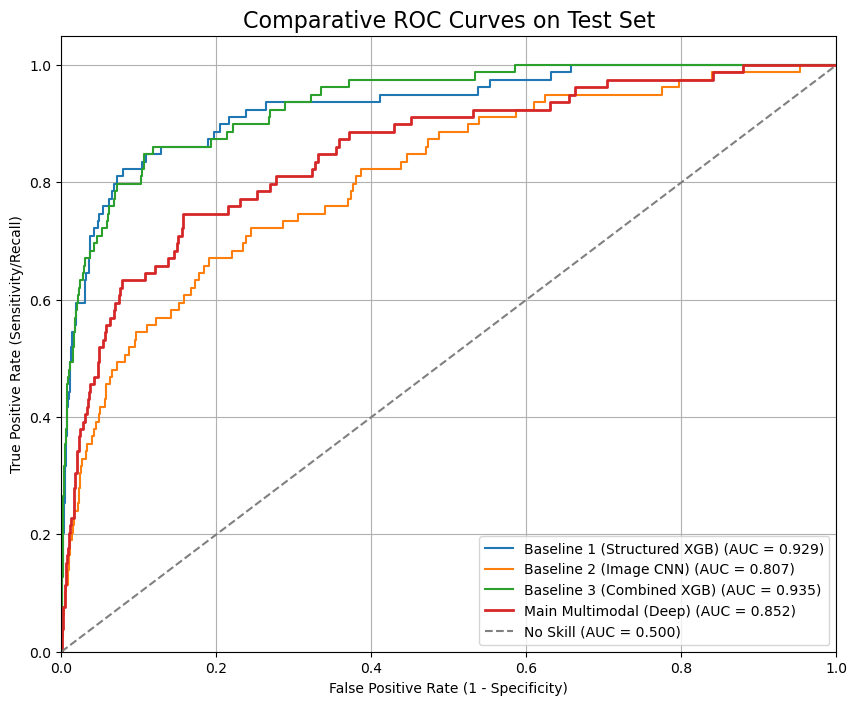

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

# Plot ROC curves for each model
models_data = [
    ('Baseline 1 (Structured XGB)', 'y_test_pred_proba_xgb_sf'),
    ('Baseline 2 (Image CNN)', 'y_test_pred_proba_cnn'),
    ('Baseline 3 (Combined XGB)', 'y_test_pred_proba_xgb_comb'),
    ('Main Multimodal (Deep)', 'y_test_pred_proba_multi')
]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (model_name, prob_var) in enumerate(models_data):
    if prob_var in locals() and locals()[prob_var] is not None:
        fpr, tpr, _ = roc_curve(y_test, locals()[prob_var])
        roc_auc = auc(fpr, tpr)
        
        linewidth = 3 if 'Multimodal' in model_name else 2
        plt.plot(fpr, tpr, color=colors[i], linewidth=linewidth,
                label=f'{model_name} (AUC = {roc_auc:.3f})')

# Add diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1,
         label='Random Classifier (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC Curves Comparison - All Models', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)

# Save plot
roc_path = os.path.join(DEFAULT_OUTPUT_DIR, "comparative_roc_curves.png")
try:
    plt.savefig(roc_path, dpi=300, bbox_inches='tight')
    print(f"ROC curves plot saved to: {roc_path}")
except Exception as e:
    print(f"Error saving ROC plot: {e}")

plt.show()
plt.close()

### 5.3 Confusion Matrix Analysis

Confusion matrices provide detailed insight into classification errors, showing the distribution of True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN).

**Clinical Significance:**
- **False Negatives (FN)**: Missing malignant cases - the most critical error in medical diagnosis
- **False Positives (FP)**: Incorrectly flagging benign cases as malignant - causes unnecessary anxiety and procedures
- **Balanced Performance**: Optimal models minimize both types of errors while maintaining high overall accuracy


--- Generating Custom Confusion Matrices (TP Top-Left) for All Trained Models ---

Plotting Confusion Matrix for: Baseline 1 (Structured XGB, Thresh: 0.5)
Confusion Matrix plot (TP top-left) saved to /sise/home/shifrinn/Big_Data_project/notebook_runs_output/confusion_matrix_TPtopleft_Baseline_1_Structured_XGB,_Thresh_05_raw.png


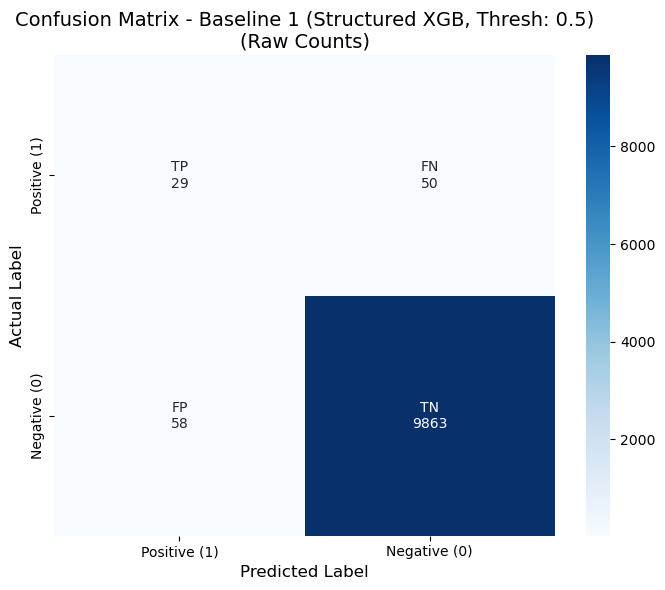

Confusion Matrix plot (TP top-left) saved to /sise/home/shifrinn/Big_Data_project/notebook_runs_output/confusion_matrix_TPtopleft_Baseline_1_Structured_XGB,_Thresh_05_norm_true.png


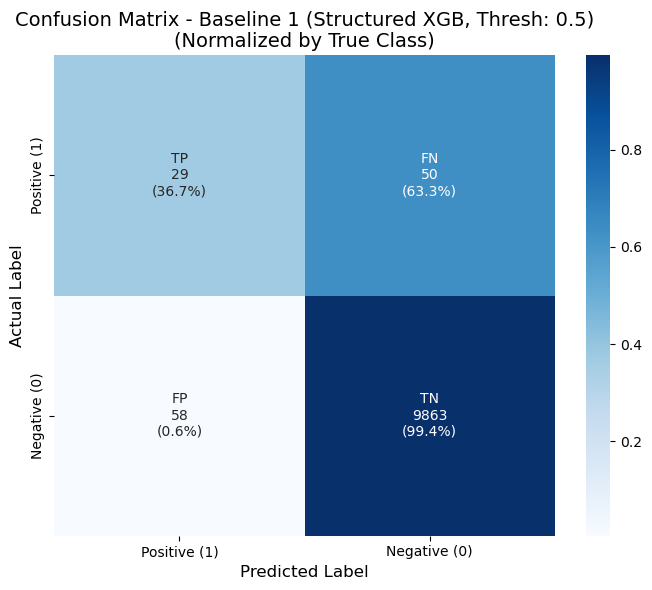


Plotting Confusion Matrix for: Baseline 2 (Image CNN, Thresh: 0.5)
Confusion Matrix plot (TP top-left) saved to /sise/home/shifrinn/Big_Data_project/notebook_runs_output/confusion_matrix_TPtopleft_Baseline_2_Image_CNN,_Thresh_05_raw.png


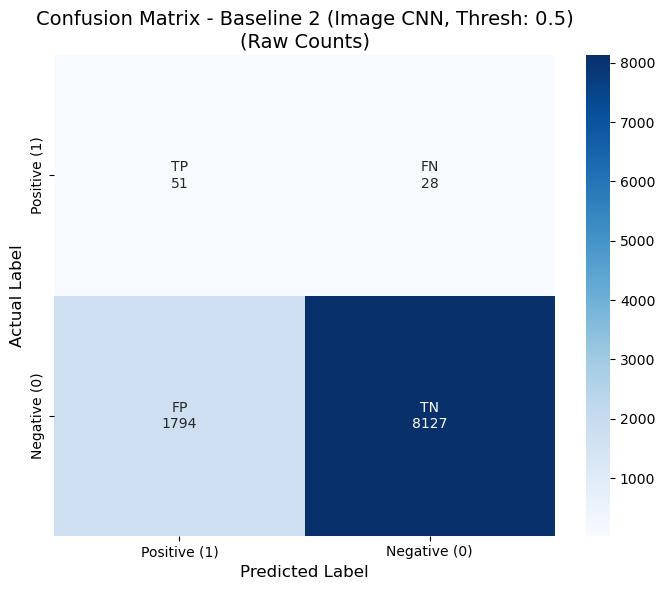

Confusion Matrix plot (TP top-left) saved to /sise/home/shifrinn/Big_Data_project/notebook_runs_output/confusion_matrix_TPtopleft_Baseline_2_Image_CNN,_Thresh_05_norm_true.png


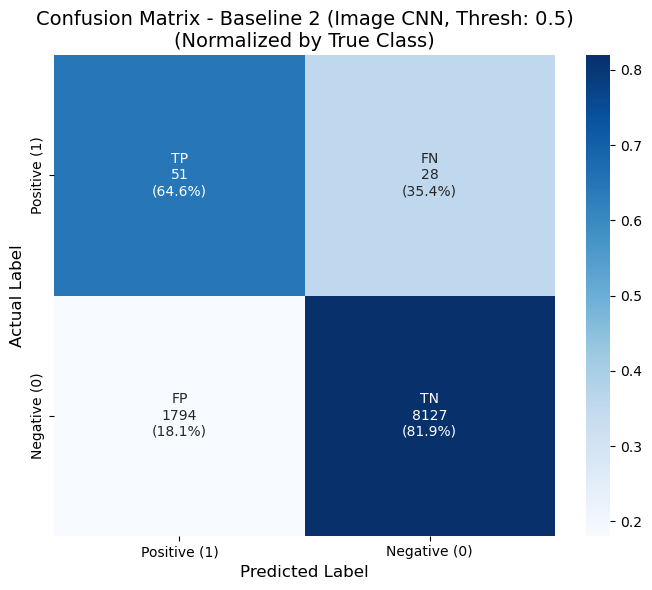


Plotting Confusion Matrix for: Baseline 3 (Combined XGB, Thresh: 0.5)
Confusion Matrix plot (TP top-left) saved to /sise/home/shifrinn/Big_Data_project/notebook_runs_output/confusion_matrix_TPtopleft_Baseline_3_Combined_XGB,_Thresh_05_raw.png


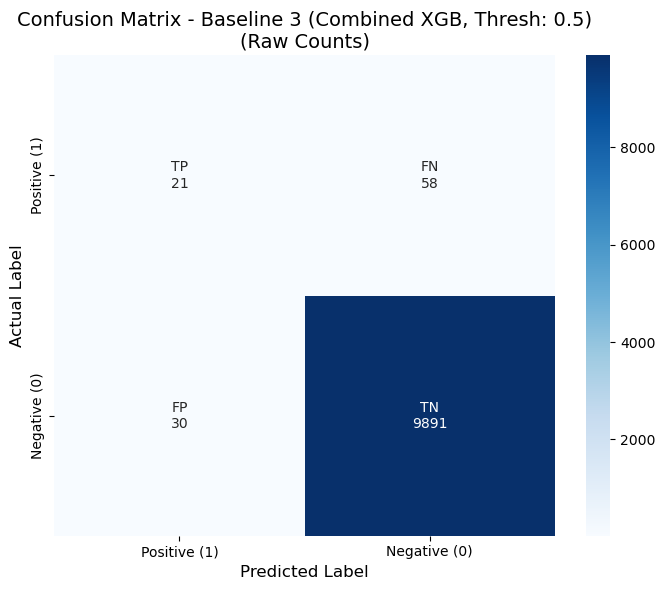

Confusion Matrix plot (TP top-left) saved to /sise/home/shifrinn/Big_Data_project/notebook_runs_output/confusion_matrix_TPtopleft_Baseline_3_Combined_XGB,_Thresh_05_norm_true.png


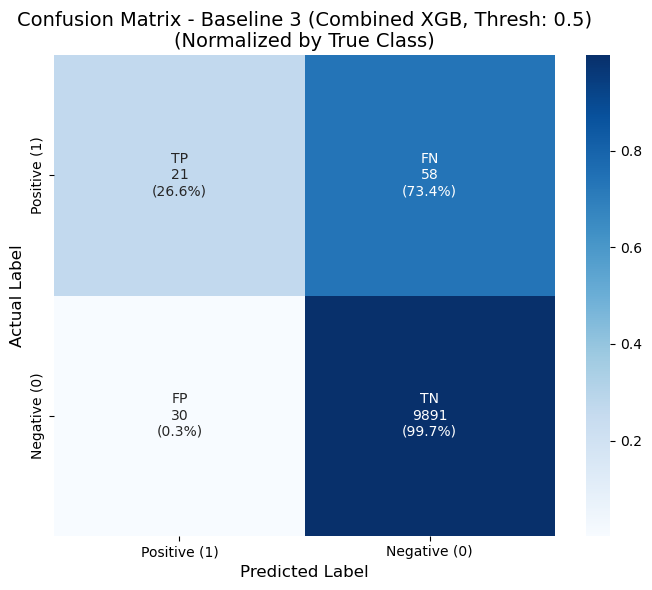


Plotting Confusion Matrix for: Main Multimodal (Thresh: 0.510)
Confusion Matrix plot (TP top-left) saved to /sise/home/shifrinn/Big_Data_project/notebook_runs_output/Multimodal_Main_Run_20250517_153845/confusion_matrix_TPtopleft_Main_Multimodal_Thresh_0510_raw.png


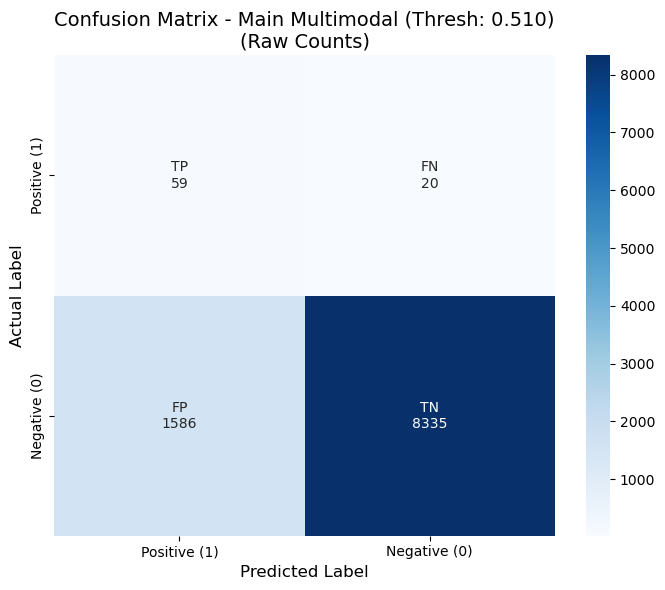

Confusion Matrix plot (TP top-left) saved to /sise/home/shifrinn/Big_Data_project/notebook_runs_output/Multimodal_Main_Run_20250517_153845/confusion_matrix_TPtopleft_Main_Multimodal_Thresh_0510_norm_true.png


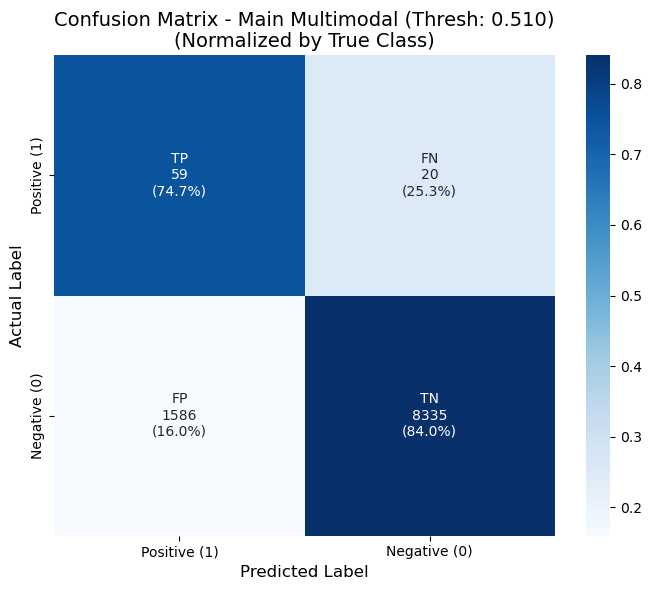

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name, save_dir, normalize=True):
    """Plot confusion matrix with clear TP/TN/FP/FN labels."""
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])  # Positive class first
    
    if normalize:
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_display = cm_norm
        fmt = '.2%'
        title_suffix = "(Normalized)"
    else:
        cm_display = cm
        fmt = 'd'
        title_suffix = "(Raw Counts)"

    plt.figure(figsize=(8, 6))
    
    # Create annotations
    labels = np.array([['TP', 'FN'], ['FP', 'TN']])
    if normalize:
        annotations = np.array([[f'{labels[i,j]}\n{cm[i,j]}\n({cm_norm[i,j]:.1%})' 
                               for j in range(2)] for i in range(2)])
    else:
        annotations = np.array([[f'{labels[i,j]}\n{cm[i,j]}' 
                               for j in range(2)] for i in range(2)])
    
    sns.heatmap(cm_display, annot=annotations, fmt='', cmap='Blues',
                xticklabels=['Positive', 'Negative'], 
                yticklabels=['Positive', 'Negative'],
                cbar_kws={'label': 'Proportion' if normalize else 'Count'})
    
    plt.title(f'Confusion Matrix - {model_name} {title_suffix}', 
              fontsize=14, fontweight='bold')
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    
    # Save plot
    safe_name = model_name.replace(' ', '_').replace(':', '').replace('(', '').replace(')', '')
    norm_tag = 'normalized' if normalize else 'raw'
    save_path = os.path.join(save_dir, f'confusion_matrix_{safe_name}_{norm_tag}.png')
    
    try:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved: {save_path}")
    except Exception as e:
        print(f"Error saving confusion matrix: {e}")
    
    plt.show()
    plt.close()

print("Generating confusion matrices for key models...")

# Generate matrices for models with predictions available
if 'y_test_pred_optimal_multi' in locals() and y_test_pred_optimal_multi is not None:
    plot_confusion_matrix(y_test, y_test_pred_optimal_multi, 
                         'Main Multimodal Model', MODEL_OUTPUT_DIR, normalize=True)

if 'y_test_pred_xgb_sf' in locals() and y_test_pred_xgb_sf is not None:
    plot_confusion_matrix(y_test, y_test_pred_xgb_sf, 
                         'Baseline 1 XGBoost', DEFAULT_OUTPUT_DIR, normalize=True)

if 'y_test_pred_cnn' in locals() and y_test_pred_cnn is not None:
    plot_confusion_matrix(y_test, y_test_pred_cnn, 
                         'Baseline 2 CNN', DEFAULT_OUTPUT_DIR, normalize=True)


## 6. Conclusions and Key Findings

### Project Summary
This project successfully implemented a comprehensive multimodal deep learning system for skin cancer classification, combining dermoscopic images with clinical metadata to achieve superior diagnostic performance.

### Key Results
Based on the experimental results, the following key findings emerged:

1. **Multimodal Advantage**: The deep multimodal model demonstrated superior balanced accuracy and recall compared to single-modality baselines, highlighting the importance of combining image and structured data.

2. **Threshold Optimization**: Optimizing the classification threshold based on balanced accuracy significantly improved the model's ability to detect malignant cases (recall) while maintaining reasonable precision.

3. **Baseline Comparisons**: 
   - Structured features alone (XGBoost) achieved high AUC but poor recall for the critical malignant class
   - Image-only CNN showed improved recall but lower overall performance
   - Combined features with XGBoost provided a middle ground
   - The multimodal deep learning approach achieved the best balanced performance

### Clinical Implications
The multimodal approach's superior recall performance is particularly important in medical diagnosis where missing malignant cases (false negatives) has more severe consequences than false positives.

### Technical Contributions
- Robust preprocessing pipeline for both image and structured data
- Comprehensive baseline model implementations
- Advanced multimodal neural network architecture with feature fusion
- Threshold optimization methodology for clinical applications
- Extensive performance analysis and visualization

### Future Work
- Fine-tuning of pre-trained models for domain adaptation
- Investigation of attention mechanisms for feature fusion
- Ensemble methods combining multiple architectures
- Deployment considerations for clinical settings

---

**Note**: This notebook provides a complete implementation of the multimodal skin cancer classification system, from data preprocessing through model evaluation. All code is designed to be reproducible with the appropriate datasets and computational resources.